# 필요한 모듈 설치

In [1]:
!pip install joblib
!pip install tqdm
!pip install koreanize-matplotlib
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


# 필요한 모듈들 import

In [2]:
# 시스템 및 환경 관련 라이브러리
import os
import random
from tqdm import tqdm
import pytz

# 데이터 분석 및 처리 라이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 관련 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier # CatBoost

# 딥러닝 및 GPU 연산 관련 라이브러리
import torch
from datetime import datetime

# 현재 날짜와 시간 정보
today = datetime.today().strftime('%m%d')

# Seed 고정 함수
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# 제출 파일 이름을 생성하는 함수
def get_submission_filename(base_path, base_filename):
    counter = 1
    submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")
    while os.path.exists(submission_path):
        counter += 1
        submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")
    return submission_path

# Connect to googld drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global Variables

In [4]:
import easydict
args = easydict.EasyDict()

# path info
args.default_path = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/data/"
args.train_csv = args.default_path + "train.csv"
args.test_csv = args.default_path + "test.csv"
args.default_submission = args.default_path + "submission.csv"
args.submit_submission = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/submission_csv/"

# 결과 저장 경로 설정
history_results_dir = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/"
history_results_path = os.path.join(history_results_dir, "history_results.csv")

# 제출용
args.submission_csv = get_submission_filename(args.submit_submission, "submission")

# 기타 설정
args.random_seed = 42

# 추후의 확인을 위한 리스트
args.results = []

# 여러 모델들을 실험하게 될텐데 최종 결과를 보고 헷갈리지 않도록 설정
model_name = ''

# 한국 타임존 설정
kst = pytz.timezone('Asia/Seoul')



# Load Titanic Dataset
- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [5]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)
default_submission = pd.read_csv(args.default_submission)

ori_train.shape, ori_test.shape, default_submission.shape

((916, 12), (393, 11), (393, 2))

In [6]:
default_submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [7]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [8]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [9]:
ori_test.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

- test 데이터셋에는 survived가 없음을 알 수 있음
- train 데이터셋에서 훈련을 위한 데이터프레임과 검증을 위한 데이터프레임을 나눠야 함.

# model_CatBoost_V0

## Train & Test Split

In [10]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [11]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [12]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [13]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [14]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [15]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [16]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [17]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [18]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [19]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [20]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


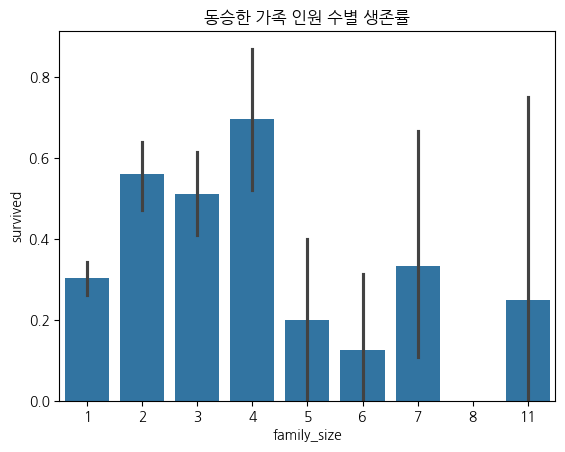

In [21]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [22]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [23]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [24]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [25]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [26]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [27]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [28]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

<ipython-input-28-f53c0921e2eb>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-28-f53c0921e2eb>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [29]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [30]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [32]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

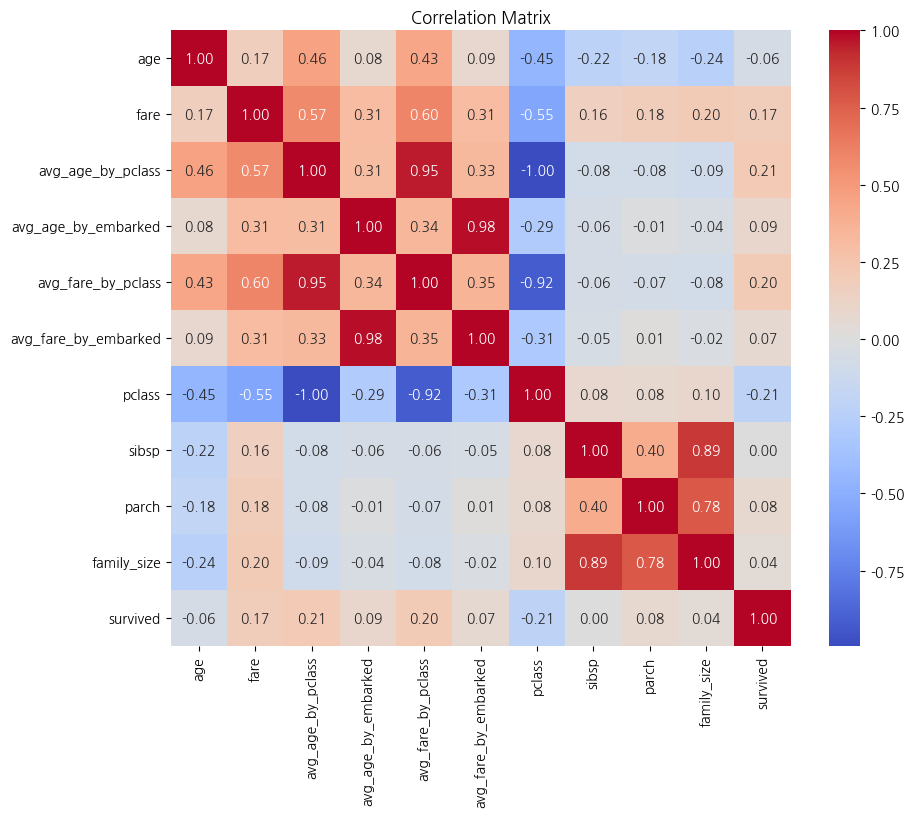

In [33]:
reset_seeds()

# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

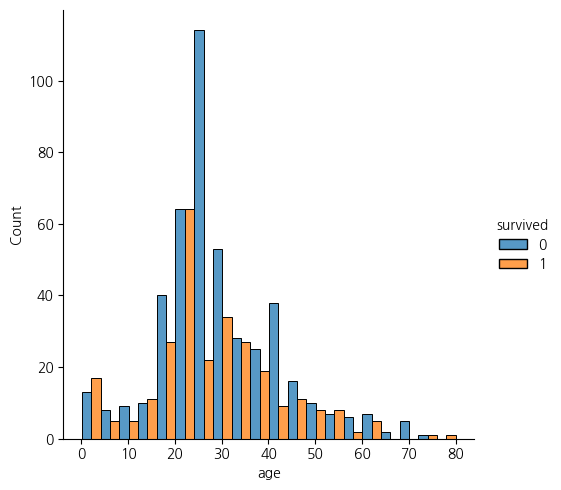

In [34]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [35]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [36]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [37]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

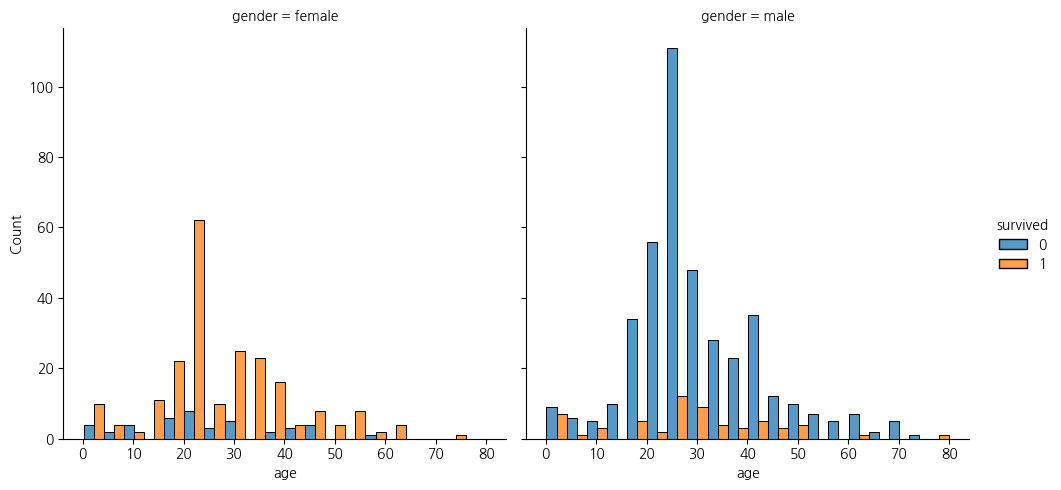

In [38]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [39]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


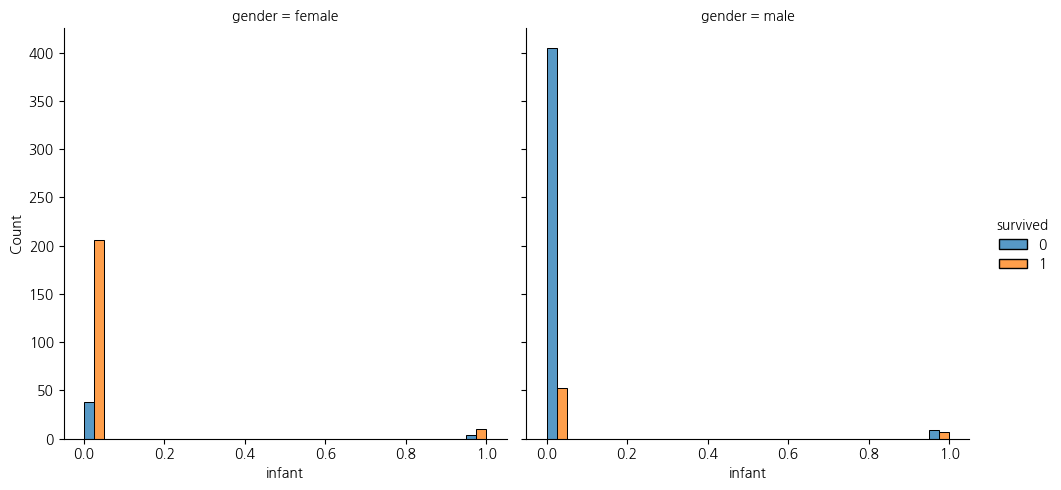

In [40]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [41]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

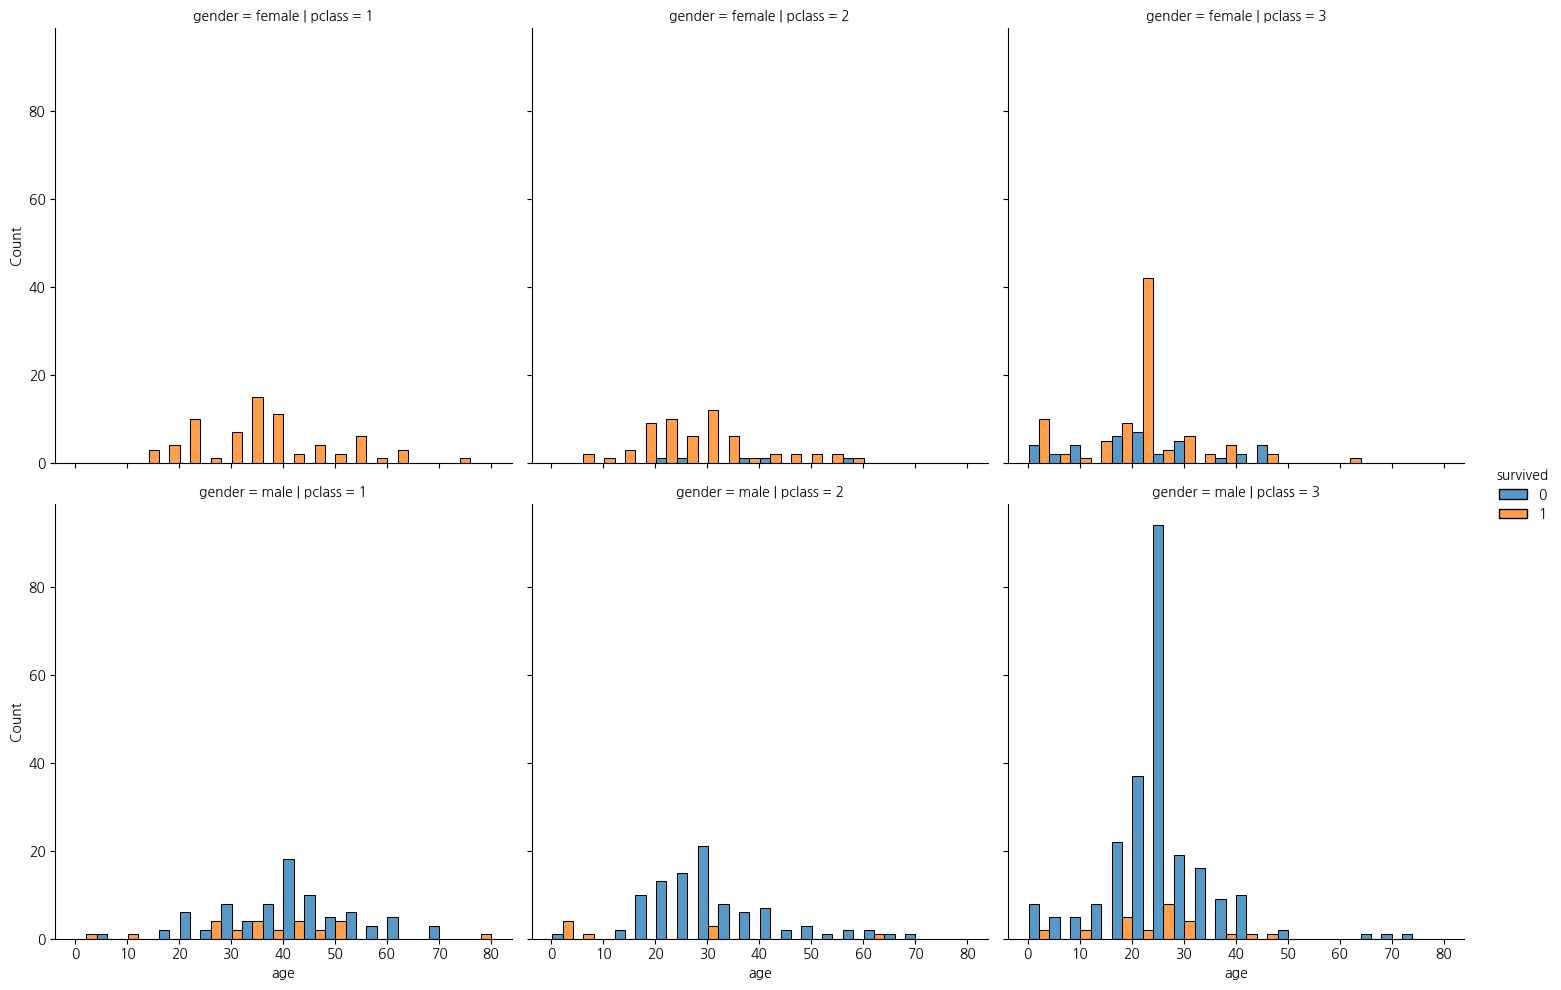

In [42]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [43]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [44]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [45]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [46]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

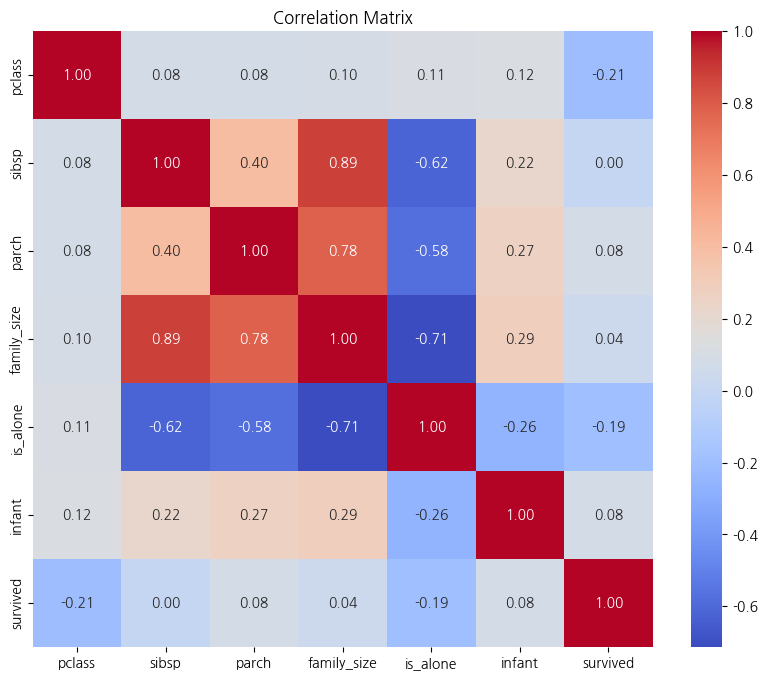

In [47]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [48]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [49]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [50]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [51]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [52]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Scaling

In [53]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23)

In [54]:
reset_seeds()

scaling_cols = ['age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
                'avg_fare_by_embarked', 'family_size']
scaler = StandardScaler()

# train 데이터프레임 스케일링
scaled_train = scaler.fit_transform(train[scaling_cols])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaling_cols)

# train의 스케일링되지 않은 컬럼
not_scaling_cols_train = list(set(train.columns) - set(scaling_cols))
train = pd.concat(
    [train[not_scaling_cols_train].reset_index(drop=True), scaled_train_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# test 데이터프레임 스케일링
scaled_test = scaler.transform(test[scaling_cols])
scaled_test_df = pd.DataFrame(scaled_test, columns=scaling_cols)

# test의 스케일링되지 않은 컬럼
not_scaling_cols_test = list(set(test.columns) - set(scaling_cols))
test = pd.concat(
    [test[not_scaling_cols_test].reset_index(drop=True), scaled_test_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# ori_te 데이터프레임 스케일링
scaled_ori_te = scaler.transform(ori_te[scaling_cols])
scaled_ori_te_df = pd.DataFrame(scaled_ori_te, columns=scaling_cols)

# ori_te의 스케일링되지 않은 컬럼
not_scaling_cols_ori_te = list(set(ori_te.columns) - set(scaling_cols))
ori_te = pd.concat(
    [ori_te[not_scaling_cols_ori_te].reset_index(drop=True), scaled_ori_te_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# 결측치 확인 및 결과 확인
print(f'{train.isnull().sum().sum()}, {test.isnull().sum().sum()}, {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0, 0, 0


((732, 23), (184, 23), (393, 22))

### Data Encoding (여기서는 진행 X)
- 분리만

In [55]:
train.columns, len(train.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   sibsp                 732 non-null    int64  
 2   infant                732 non-null    int64  
 3   has_cabin             732 non-null    int64  
 4   pclass                732 non-null    int64  
 5   infant_family_size    732 non-null    object 
 6   gender                732 non-null    object 
 7   embarked              732 non-null    object 
 8   survived              732 non-null    int64  
 9   gender_pclass         732 non-null    object 
 10  gender_infant         732 non-null    object 
 11  pclass_family_size    732 non-null    object 
 12  infant_pclass         732 non-null    object 
 13  pclass_is_alone       732 non-null    object 
 14  is_alone              732 non-null    int64  
 15  parch                 7

In [57]:
train.select_dtypes(include=np.number)

,passengerid,sibsp,infant,has_cabin,pclass,survived,is_alone,parch,age,fare,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
0,914,0,0,0,3,1,1,0,-0.573408,-0.514795,-0.817102,-0.614033,-0.638555,-1.185388,-0.566752
1,805,4,0,0,3,0,0,2,-1.727349,0.012145,-0.817102,-0.484440,-0.638555,-0.399678,3.415925
2,255,1,1,0,3,1,0,1,-2.101644,-0.415190,-0.817102,-0.484440,-0.638555,-0.399678,0.760807
3,769,0,0,0,3,0,1,0,3.101048,-0.514421,-0.817102,-0.614033,-0.638555,-1.185388,-0.566752
4,527,0,0,0,3,0,1,0,0.443558,-0.528411,-0.817102,-0.484440,-0.638555,-0.399678,-0.566752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,403,0,1,0,3,1,0,2,-2.101644,-0.335541,-0.817102,2.002093,-0.638555,1.953991,0.760807
728,824,0,0,0,3,0,1,0,0.368699,-0.507706,-0.817102,-0.484440,-0.638555,-0.399678,-0.566752
729,879,0,0,0,3,0,0,2,-1.427914,-0.147336,-0.817102,-0.484440,-0.638555,-0.399678,0.760807
730,214,0,0,1,1,0,1,0,-0.379890,1.084863,1.629847,2.002093,1.767622,1.953991,-0.566752


In [58]:
train.select_dtypes(exclude=np.number)

,infant_family_size,gender,embarked,gender_pclass,gender_infant,pclass_family_size,infant_pclass,pclass_is_alone
0,0_1,female,Q,female_3,female_0,3_1,0_3,3_1
1,0_7,female,S,female_3,female_0,3_7,0_3,3_0
2,1_3,female,S,female_3,female_1,3_3,1_3,3_0
3,0_1,male,Q,male_3,male_0,3_1,0_3,3_1
4,0_1,male,S,male_3,male_0,3_1,0_3,3_1
...,...,...,...,...,...,...,...,...
727,1_3,female,C,female_3,female_1,3_3,1_3,3_0
728,0_1,male,S,male_3,male_0,3_1,0_3,3_1
729,0_3,female,S,female_3,female_0,3_3,0_3,3_0
730,0_1,male,C,male_1,male_0,1_1,0_1,1_1


In [59]:
train.columns, len(train.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23)

In [60]:
# 범주형 컬럼 리스트
enc_cols = ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender',
                    'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin']

# 수치형 컬럼들
normal_cols = list(set(train.columns) - set(enc_cols)- {'survived'})

print(f"범주형 컬럼들 : {enc_cols} / 수치형 컬럼들 : {normal_cols}")
print(f"범주형 컬럼들 개수: {len(enc_cols)} / 수치형 컬럼들 개수 : {len(normal_cols)}")

범주형 컬럼들 : ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender', 'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin'] / 수치형 컬럼들 : ['passengerid', 'sibsp', 'avg_age_by_pclass', 'infant', 'avg_fare_by_pclass', 'fare', 'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'is_alone', 'parch', 'age']
범주형 컬럼들 개수: 10 / 수치형 컬럼들 개수 : 12


In [61]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'gender_pclass',
        'gender_in

### 범주형 컬럼과 스케일링한 컬럼들을 합치기

In [62]:
reset_seeds()
print(f'before: {train.shape}, {test.shape}, {ori_te.shape}')

# train, test, ori_te 데이터에서 해당 컬럼들을 범주형으로 변환
for df in [train, test, ori_te]:
    df[enc_cols] = df[enc_cols].astype('category')

# 스케일링된 수치형 컬럼 + 범주형 컬럼 합치기
train = pd.concat([train[enc_cols].reset_index(drop=True), train[normal_cols + ['survived']].reset_index(drop=True)], axis=1)
test = pd.concat([test[enc_cols].reset_index(drop=True), test[normal_cols + ['survived']].reset_index(drop=True)], axis=1)
ori_te = pd.concat([ori_te[enc_cols].reset_index(drop=True), ori_te[normal_cols].reset_index(drop=True)], axis=1)

# 결과 출력
print(f'after: {train.shape}, {test.shape}, {ori_te.shape}')
train.head()

before: (732, 23), (184, 23), (393, 22)
after: (732, 23), (184, 23), (393, 22)


,pclass,gender_infant,pclass_family_size,infant_pclass,gender,infant_family_size,embarked,gender_pclass,pclass_is_alone,has_cabin,...,infant,avg_fare_by_pclass,fare,family_size,avg_age_by_embarked,avg_fare_by_embarked,is_alone,parch,age,survived
0,3,female_0,3_1,0_3,female,0_1,Q,female_3,3_1,0,...,0,-0.638555,-0.514795,-0.566752,-0.614033,-1.185388,1,0,-0.573408,1
1,3,female_0,3_7,0_3,female,0_7,S,female_3,3_0,0,...,0,-0.638555,0.012145,3.415925,-0.484440,-0.399678,0,2,-1.727349,0
2,3,female_1,3_3,1_3,female,1_3,S,female_3,3_0,0,...,1,-0.638555,-0.415190,0.760807,-0.484440,-0.399678,0,1,-2.101644,1
3,3,male_0,3_1,0_3,male,0_1,Q,male_3,3_1,0,...,0,-0.638555,-0.514421,-0.566752,-0.614033,-1.185388,1,0,3.101048,0
4,3,male_0,3_1,0_3,male,0_1,S,male_3,3_1,0,...,0,-0.638555,-0.528411,-0.566752,-0.484440,-0.399678,1,0,0.443558,0


## Training

In [63]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [64]:
reset_seeds()

y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((732, 22), (732,), (184, 22), (184,))

In [65]:
# reset_seeds()

# model_name = 'model_cat_V0'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의 (CatBoost 전용)
# param_dist = {
#     'iterations': list(range(500, 3001, 100)),
#     'depth': list(range(4, 12)),
#     'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
#     'l2_leaf_reg': [1, 3, 5, 7, 10],
#     'border_count': [32, 64, 128, 256],
#     'bagging_temperature': [0.0, 0.5, 1.0],
#     'random_strength': [1, 5, 10],
#     'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
#     'loss_function': ['Logloss'],
#     'eval_metric': ['AUC'],
#     'boosting_type': ['Ordered', 'Plain'],
#     'verbose': [0]
# }

# # 범주형 컬럼 리스트
# cat_features = enc_cols

# # CatBoost 모델 초기화
# model_cat_V0 = CatBoostClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_cat_V0, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr, cat_features=cat_features)

In [66]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [67]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_cat_V0_best = CatBoostClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_cat_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_cat_V0_best.fit(X_tr, y_tr)

In [68]:
reset_seeds()

model_name = 'model_cat_V0'

parameters = {
    'iterations': 1500,
    'depth': 8,
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'border_count': 128,
    'bagging_temperature': 0.5,
    'random_strength': 5,
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'boosting_type': 'Ordered',
    'verbose': 100,
    'random_seed': args.random_seed
}


# 범주형 컬럼 리스트
cat_features = enc_cols

model_cat_V0 = CatBoostClassifier(**parameters)
# model_cat_V0 = CatBoostClassifier(**parameters, task_type="GPU")

# 모델 훈련 (범주형 컬럼 포함)
model_cat_V0.fit(X_tr, y_tr, cat_features=cat_features)

0:	total: 82.4ms	remaining: 2m 3s
100:	total: 4.3s	remaining: 59.6s
200:	total: 10.1s	remaining: 1m 5s
300:	total: 15s	remaining: 59.9s
400:	total: 19.7s	remaining: 53.9s
500:	total: 26.3s	remaining: 52.5s
600:	total: 31.1s	remaining: 46.5s
700:	total: 37s	remaining: 42.2s
800:	total: 42.6s	remaining: 37.2s
900:	total: 49.6s	remaining: 33s
1000:	total: 55.7s	remaining: 27.8s
1100:	total: 1m	remaining: 21.9s
1200:	total: 1m 6s	remaining: 16.6s
1300:	total: 1m 11s	remaining: 11s
1400:	total: 1m 16s	remaining: 5.41s
1499:	total: 1m 22s	remaining: 0us


## Evaluation (평가)

In [69]:
reset_seeds()

# CatBoost 모델
# - Train data
score_tr_cat = model_cat_V0.score(X_tr, y_tr)
# - Test data
score_te_cat = model_cat_V0.score(X_te, y_te)

print(f'{model_cat_V0} : {score_tr_cat}, {score_te_cat}')

<catboost.core.CatBoostClassifier object at 0x78f3e7af2f50> : 0.9193989071038251, 0.875


### AUC 점수

In [70]:
reset_seeds()

y_pred = model_cat_V0.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_cat_V0}: {auc_te}')

<catboost.core.CatBoostClassifier object at 0x78f3e7af2f50>: 0.905764411027569


### 혼동행렬

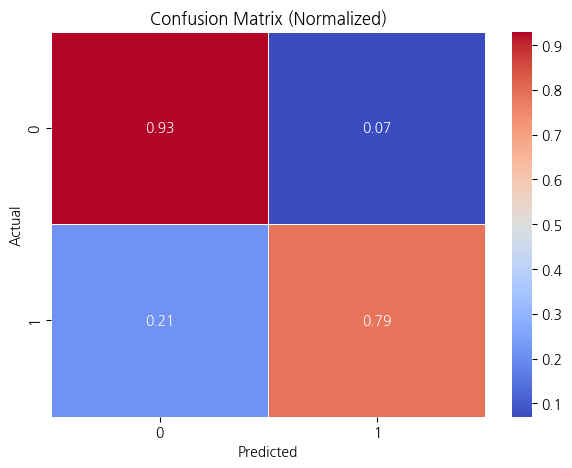

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_cat_V0.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [72]:
reset_seeds()

ori_te_pred = model_cat_V0.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [73]:
df_feature_importances = pd.DataFrame(model_cat_V0.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


,index,0
0,gender_pclass,22.318347
1,gender_infant,11.741422
2,passengerid,11.017422
3,fare,10.272417
4,age,6.887165
5,pclass_is_alone,6.181161
6,embarked,6.041253
7,infant_pclass,5.617521
8,pclass_family_size,4.780545
9,infant_family_size,3.126159


### 결과 정리

In [74]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_cat,
        'score_te': score_te_cat,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [75]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,model_cat_V0,"{'iterations': 1500, 'depth': 8, 'learning_rat...",0.919399,0.875,0.905764,"[0.9846089897632051, 0.9596377785533127, 0.988...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28


# model_CatBoost_V1 (random search 진행)

## Train & Test Split

In [76]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [77]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [78]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [79]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [80]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [81]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [82]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [83]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [84]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [85]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [86]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


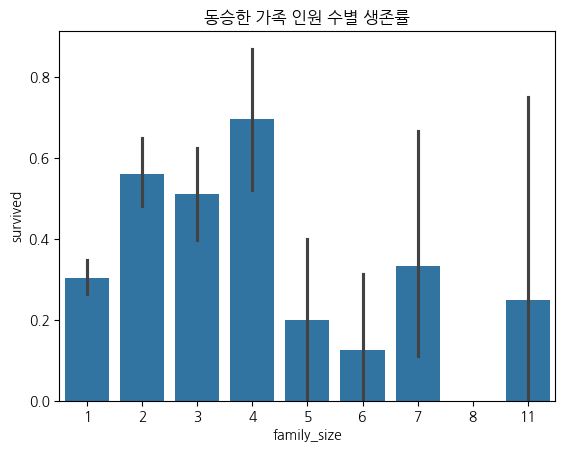

In [87]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [88]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [89]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [90]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [91]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [92]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [93]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [94]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

<ipython-input-94-f53c0921e2eb>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-94-f53c0921e2eb>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [95]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [96]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [98]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

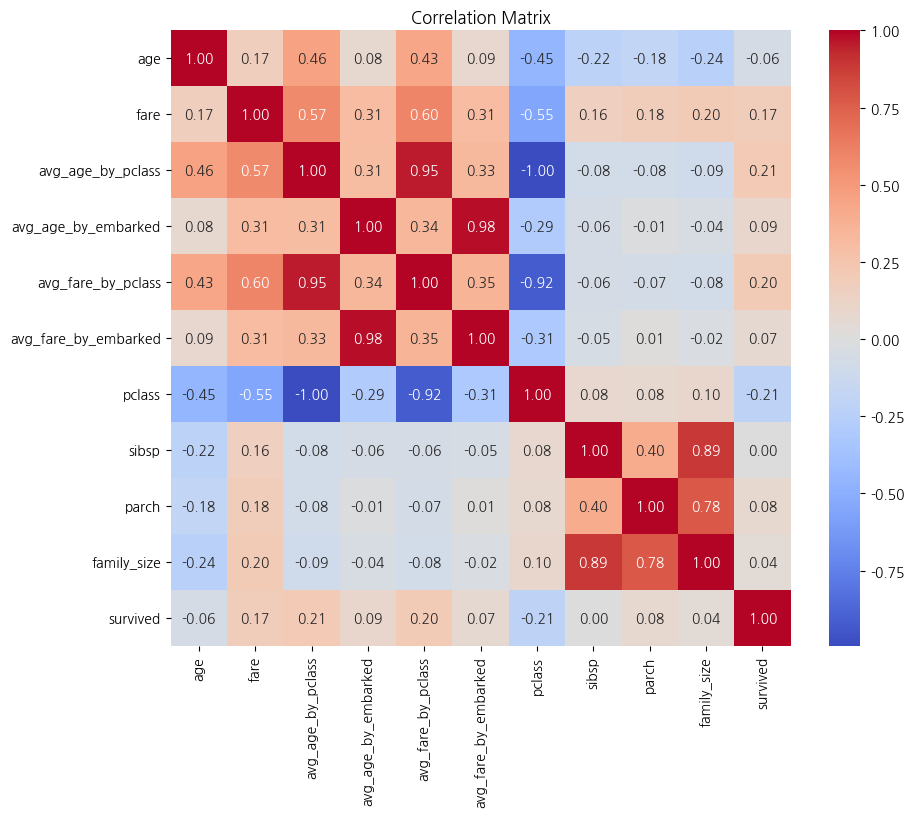

In [99]:
reset_seeds()

# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

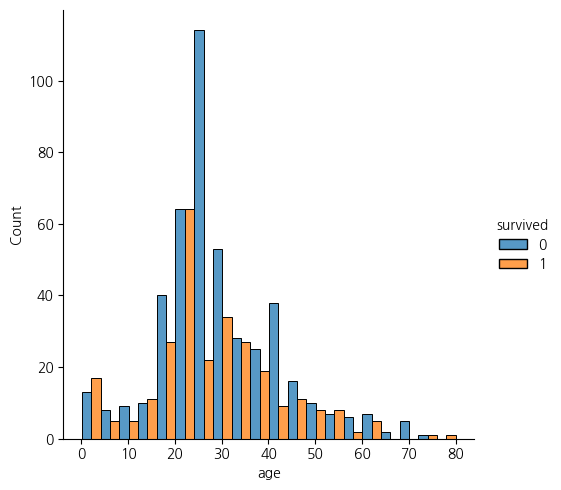

In [100]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [101]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [102]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [103]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

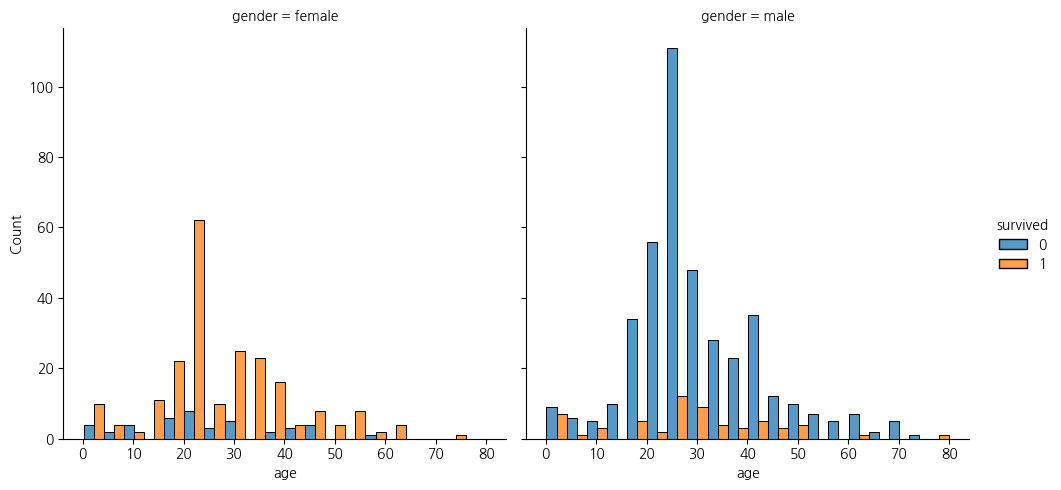

In [104]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [105]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


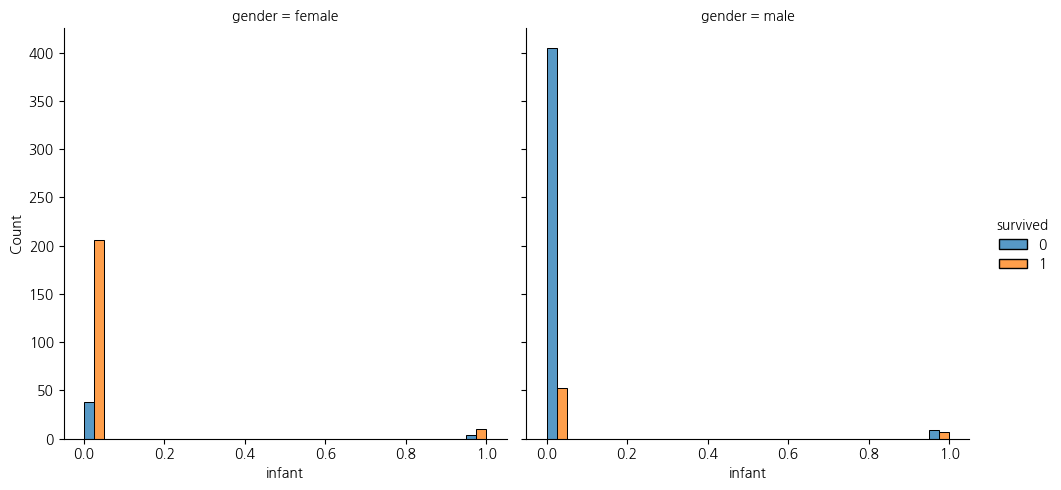

In [106]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [107]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

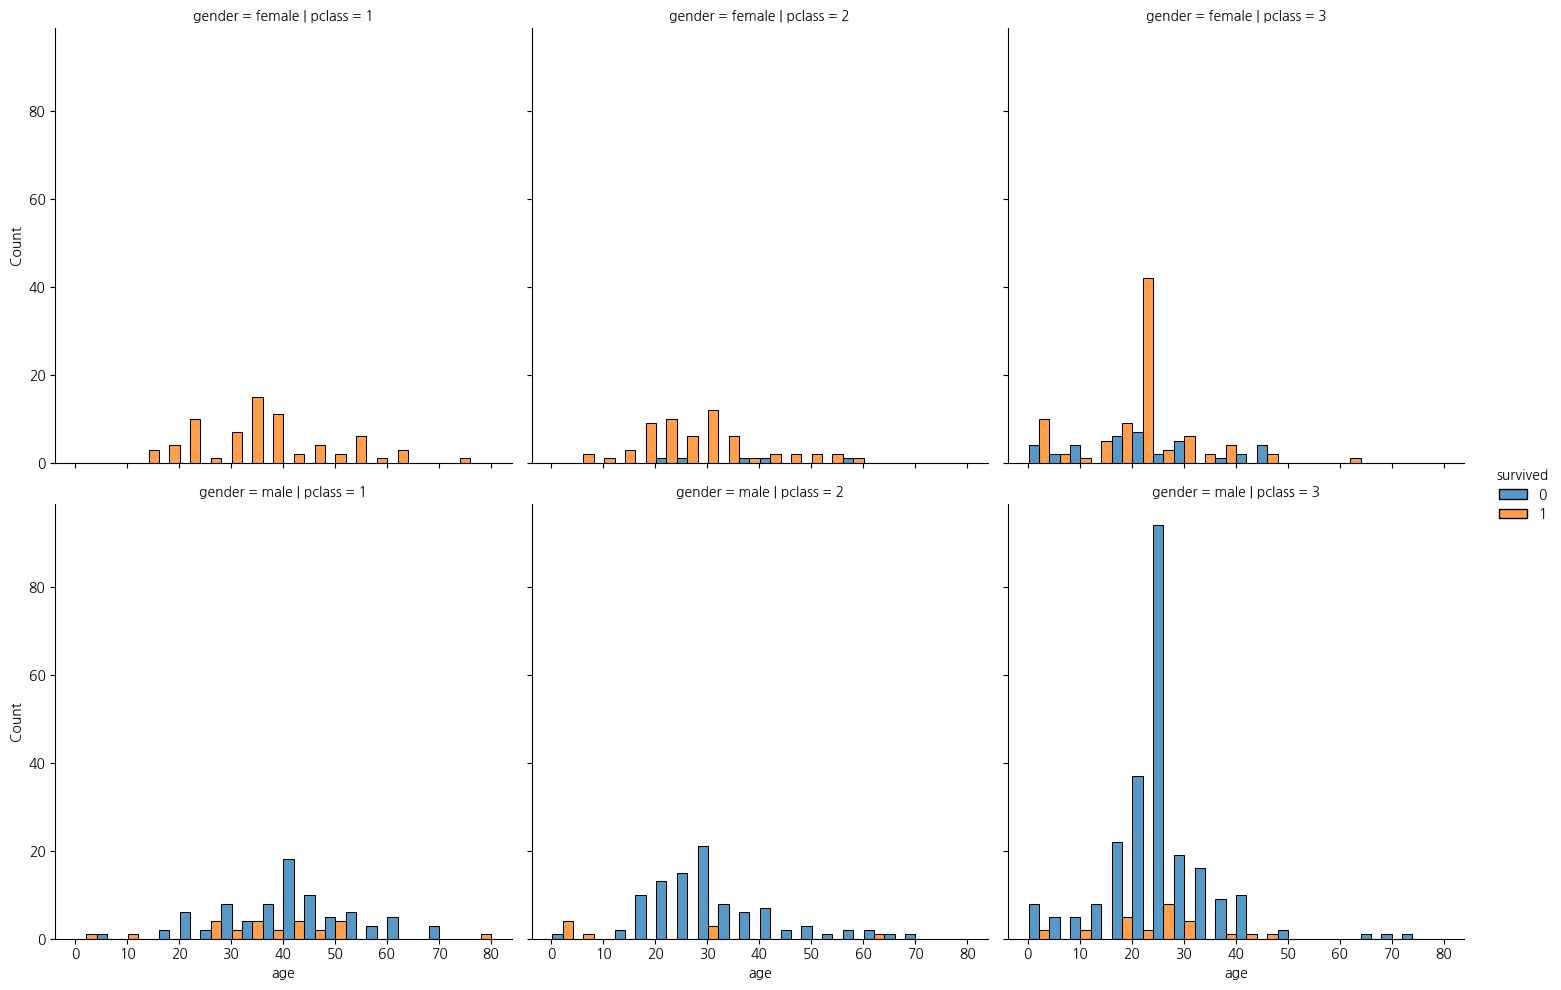

In [108]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [109]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [110]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [111]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [112]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

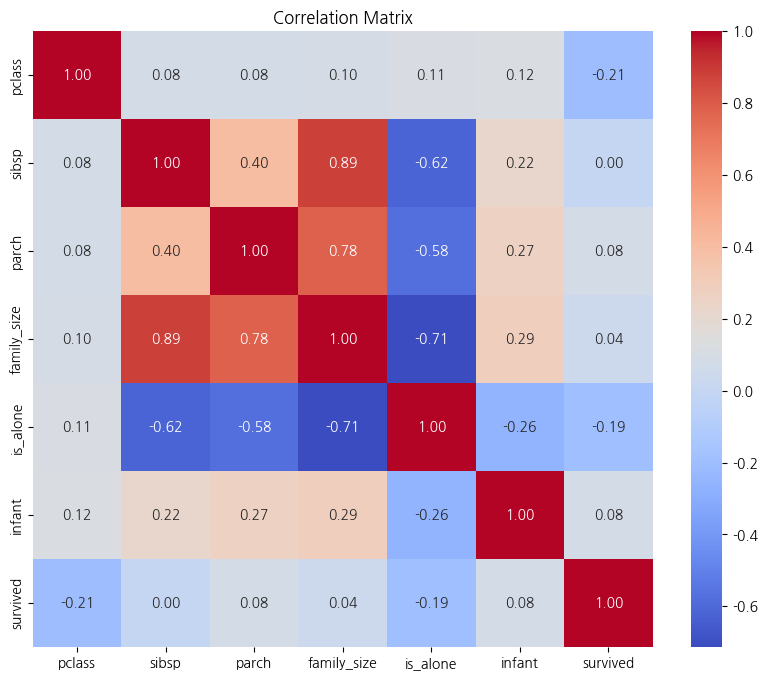

In [113]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [114]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [115]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [116]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [117]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [118]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Scaling

In [119]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23)

In [120]:
reset_seeds()

scaling_cols = ['age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
                'avg_fare_by_embarked', 'family_size']
scaler = StandardScaler()

# train 데이터프레임 스케일링
scaled_train = scaler.fit_transform(train[scaling_cols])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaling_cols)

# train의 스케일링되지 않은 컬럼
not_scaling_cols_train = list(set(train.columns) - set(scaling_cols))
train = pd.concat(
    [train[not_scaling_cols_train].reset_index(drop=True), scaled_train_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# test 데이터프레임 스케일링
scaled_test = scaler.transform(test[scaling_cols])
scaled_test_df = pd.DataFrame(scaled_test, columns=scaling_cols)

# test의 스케일링되지 않은 컬럼
not_scaling_cols_test = list(set(test.columns) - set(scaling_cols))
test = pd.concat(
    [test[not_scaling_cols_test].reset_index(drop=True), scaled_test_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# ori_te 데이터프레임 스케일링
scaled_ori_te = scaler.transform(ori_te[scaling_cols])
scaled_ori_te_df = pd.DataFrame(scaled_ori_te, columns=scaling_cols)

# ori_te의 스케일링되지 않은 컬럼
not_scaling_cols_ori_te = list(set(ori_te.columns) - set(scaling_cols))
ori_te = pd.concat(
    [ori_te[not_scaling_cols_ori_te].reset_index(drop=True), scaled_ori_te_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# 결측치 확인 및 결과 확인
print(f'{train.isnull().sum().sum()}, {test.isnull().sum().sum()}, {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0, 0, 0


((732, 23), (184, 23), (393, 22))

### Data Encoding (여기서는 진행 X)
- 분리만

In [121]:
train.columns, len(train.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23)

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   sibsp                 732 non-null    int64  
 2   infant                732 non-null    int64  
 3   has_cabin             732 non-null    int64  
 4   pclass                732 non-null    int64  
 5   infant_family_size    732 non-null    object 
 6   gender                732 non-null    object 
 7   embarked              732 non-null    object 
 8   survived              732 non-null    int64  
 9   gender_pclass         732 non-null    object 
 10  gender_infant         732 non-null    object 
 11  pclass_family_size    732 non-null    object 
 12  infant_pclass         732 non-null    object 
 13  pclass_is_alone       732 non-null    object 
 14  is_alone              732 non-null    int64  
 15  parch                 7

In [123]:
train.select_dtypes(include=np.number)

,passengerid,sibsp,infant,has_cabin,pclass,survived,is_alone,parch,age,fare,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
0,914,0,0,0,3,1,1,0,-0.573408,-0.514795,-0.817102,-0.614033,-0.638555,-1.185388,-0.566752
1,805,4,0,0,3,0,0,2,-1.727349,0.012145,-0.817102,-0.484440,-0.638555,-0.399678,3.415925
2,255,1,1,0,3,1,0,1,-2.101644,-0.415190,-0.817102,-0.484440,-0.638555,-0.399678,0.760807
3,769,0,0,0,3,0,1,0,3.101048,-0.514421,-0.817102,-0.614033,-0.638555,-1.185388,-0.566752
4,527,0,0,0,3,0,1,0,0.443558,-0.528411,-0.817102,-0.484440,-0.638555,-0.399678,-0.566752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,403,0,1,0,3,1,0,2,-2.101644,-0.335541,-0.817102,2.002093,-0.638555,1.953991,0.760807
728,824,0,0,0,3,0,1,0,0.368699,-0.507706,-0.817102,-0.484440,-0.638555,-0.399678,-0.566752
729,879,0,0,0,3,0,0,2,-1.427914,-0.147336,-0.817102,-0.484440,-0.638555,-0.399678,0.760807
730,214,0,0,1,1,0,1,0,-0.379890,1.084863,1.629847,2.002093,1.767622,1.953991,-0.566752


In [124]:
train.select_dtypes(exclude=np.number)

,infant_family_size,gender,embarked,gender_pclass,gender_infant,pclass_family_size,infant_pclass,pclass_is_alone
0,0_1,female,Q,female_3,female_0,3_1,0_3,3_1
1,0_7,female,S,female_3,female_0,3_7,0_3,3_0
2,1_3,female,S,female_3,female_1,3_3,1_3,3_0
3,0_1,male,Q,male_3,male_0,3_1,0_3,3_1
4,0_1,male,S,male_3,male_0,3_1,0_3,3_1
...,...,...,...,...,...,...,...,...
727,1_3,female,C,female_3,female_1,3_3,1_3,3_0
728,0_1,male,S,male_3,male_0,3_1,0_3,3_1
729,0_3,female,S,female_3,female_0,3_3,0_3,3_0
730,0_1,male,C,male_1,male_0,1_1,0_1,1_1


In [125]:
train.columns, len(train.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23)

In [126]:
# 범주형 컬럼 리스트
enc_cols = ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender',
                    'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin']

# 수치형 컬럼들
normal_cols = list(set(train.columns) - set(enc_cols)- {'survived'})

print(f"범주형 컬럼들 : {enc_cols} / 수치형 컬럼들 : {normal_cols}")
print(f"범주형 컬럼들 개수: {len(enc_cols)} / 수치형 컬럼들 개수 : {len(normal_cols)}")

범주형 컬럼들 : ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender', 'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin'] / 수치형 컬럼들 : ['passengerid', 'sibsp', 'avg_age_by_pclass', 'infant', 'avg_fare_by_pclass', 'fare', 'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'is_alone', 'parch', 'age']
범주형 컬럼들 개수: 10 / 수치형 컬럼들 개수 : 12


In [127]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'gender_pclass',
        'gender_in

### 범주형 컬럼과 스케일링한 컬럼들을 합치기

In [128]:
reset_seeds()
print(f'before: {train.shape}, {test.shape}, {ori_te.shape}')

# train, test, ori_te 데이터에서 해당 컬럼들을 범주형으로 변환
for df in [train, test, ori_te]:
    df[enc_cols] = df[enc_cols].astype('category')

# 스케일링된 수치형 컬럼 + 범주형 컬럼 합치기
train = pd.concat([train[enc_cols].reset_index(drop=True), train[normal_cols + ['survived']].reset_index(drop=True)], axis=1)
test = pd.concat([test[enc_cols].reset_index(drop=True), test[normal_cols + ['survived']].reset_index(drop=True)], axis=1)
ori_te = pd.concat([ori_te[enc_cols].reset_index(drop=True), ori_te[normal_cols].reset_index(drop=True)], axis=1)

# 결과 출력
print(f'after: {train.shape}, {test.shape}, {ori_te.shape}')
train.head()

before: (732, 23), (184, 23), (393, 22)
after: (732, 23), (184, 23), (393, 22)


,pclass,gender_infant,pclass_family_size,infant_pclass,gender,infant_family_size,embarked,gender_pclass,pclass_is_alone,has_cabin,...,infant,avg_fare_by_pclass,fare,family_size,avg_age_by_embarked,avg_fare_by_embarked,is_alone,parch,age,survived
0,3,female_0,3_1,0_3,female,0_1,Q,female_3,3_1,0,...,0,-0.638555,-0.514795,-0.566752,-0.614033,-1.185388,1,0,-0.573408,1
1,3,female_0,3_7,0_3,female,0_7,S,female_3,3_0,0,...,0,-0.638555,0.012145,3.415925,-0.484440,-0.399678,0,2,-1.727349,0
2,3,female_1,3_3,1_3,female,1_3,S,female_3,3_0,0,...,1,-0.638555,-0.415190,0.760807,-0.484440,-0.399678,0,1,-2.101644,1
3,3,male_0,3_1,0_3,male,0_1,Q,male_3,3_1,0,...,0,-0.638555,-0.514421,-0.566752,-0.614033,-1.185388,1,0,3.101048,0
4,3,male_0,3_1,0_3,male,0_1,S,male_3,3_1,0,...,0,-0.638555,-0.528411,-0.566752,-0.484440,-0.399678,1,0,0.443558,0


## Training

In [129]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [130]:
reset_seeds()

y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((732, 22), (732,), (184, 22), (184,))

In [131]:
# reset_seeds()

# model_name = 'model_cat_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'iterations': list(range(500, 1501, 250)),
#     'depth': list(range(4, 10)),
#     'learning_rate': [0.01, 0.05, 0.1],
#     'l2_leaf_reg': [1, 5, 10],
#     'boosting_type': ['Ordered', 'Plain'],
#     'random_seed': [42]
# }

# # 범주형 컬럼 리스트
# cat_features = enc_cols

# X_tr[cat_features] = X_tr[cat_features].astype('category')
# X_te[cat_features] = X_te[cat_features].astype('category')

# # CatBoost 모델 초기화
# # model_cat_V1 = CatBoostClassifier(random_seed=args.random_seed, task_type="GPU")
# model_cat_V1 = CatBoostClassifier(random_seed=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_cat_V1, param_distributions=param_dist,
#     n_iter=50,
#     cv=5,
#     scoring='roc_auc', random_state=42,
#     n_jobs=-1,
#     verbose=2
# )


# random_search.fit(X_tr, y_tr, cat_features=cat_features, early_stopping_rounds=50)

In [132]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [133]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_cat_V1_best = CatBoostClassifier(**parameters)
# print(f'{model_cat_V1_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_cat_V1_best.fit(X_tr, y_tr, cat_features=cat_features)

In [134]:
reset_seeds()

model_name = 'model_cat_V1'

parameters = {
    'random_seed': 42,
    'learning_rate': 0.01,
    'l2_leaf_reg': 1,
    'iterations': 1500,
    'depth': 8,
    'boosting_type': 'Ordered',
    'verbose' : 100
}

# 범주형 컬럼 리스트
cat_features = enc_cols

# 범주형 컬럼을 category 형식으로 변환 (메모리 절약)
X_tr[cat_features] = X_tr[cat_features].astype('category')
X_te[cat_features] = X_te[cat_features].astype('category')

# CatBoost 모델 초기화
# model_cat_V1 = CatBoostClassifier(random_seed=args.random_seed, task_type="GPU")
model_cat_V1 = CatBoostClassifier(**parameters)

model_cat_V1.fit(X_tr, y_tr, cat_features=cat_features)

0:	learn: 0.6844177	total: 8.18ms	remaining: 12.3s
100:	learn: 0.3892118	total: 3.37s	remaining: 46.7s
200:	learn: 0.3453097	total: 4.96s	remaining: 32.1s
300:	learn: 0.3243417	total: 6.64s	remaining: 26.5s
400:	learn: 0.3123458	total: 8.17s	remaining: 22.4s
500:	learn: 0.2998432	total: 10.4s	remaining: 20.8s
600:	learn: 0.2902850	total: 12.3s	remaining: 18.5s
700:	learn: 0.2779632	total: 16s	remaining: 18.2s
800:	learn: 0.2631520	total: 19.9s	remaining: 17.4s
900:	learn: 0.2439418	total: 24.4s	remaining: 16.2s
1000:	learn: 0.2260972	total: 32.2s	remaining: 16.1s
1100:	learn: 0.2103588	total: 37.2s	remaining: 13.5s
1200:	learn: 0.1961384	total: 44.4s	remaining: 11s
1300:	learn: 0.1839322	total: 49.7s	remaining: 7.6s
1400:	learn: 0.1721495	total: 54.7s	remaining: 3.86s
1499:	learn: 0.1623729	total: 1m 1s	remaining: 0us


## Evaluation (평가)

In [135]:
reset_seeds()

# CatBoost 모델
# - Train data
score_tr_cat = model_cat_V1.score(X_tr, y_tr)
# - Test data
score_te_cat = model_cat_V1.score(X_te, y_te)

print(f'{model_cat_V1} : {score_tr_cat}, {score_te_cat}')

<catboost.core.CatBoostClassifier object at 0x78f3defb2590> : 0.9030054644808743, 0.8695652173913043


### AUC 점수

In [136]:
reset_seeds()

y_pred = model_cat_V1.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_cat_V1}: {auc_te}')

<catboost.core.CatBoostClassifier object at 0x78f3defb2590>: 0.9116541353383458


### 혼동행렬

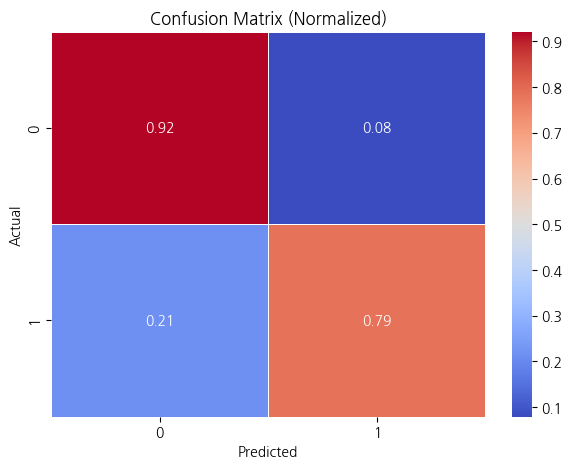

In [137]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_cat_V1.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [138]:
reset_seeds()

ori_te_pred = model_cat_V1.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [139]:
df_feature_importances = pd.DataFrame(model_cat_V1.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


,index,0
0,gender_pclass,17.991396
1,gender_infant,14.341572
2,passengerid,9.999885
3,age,6.955504
4,infant_pclass,6.705328
5,fare,6.475495
6,embarked,5.675414
7,gender,5.445801
8,pclass_is_alone,4.309611
9,pclass_family_size,3.948401


### 결과 정리

In [140]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_cat,
        'score_te': score_te_cat,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [141]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
1,model_cat_V1,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.903005,0.869565,0.911654,"[0.9566383013903034, 0.9289832713644142, 0.956...",22,"[gender_pclass, gender_infant, passengerid, ag...",2025-02-12 13:31:28
0,model_cat_V0,"{'iterations': 1500, 'depth': 8, 'learning_rat...",0.919399,0.875000,0.905764,"[0.9846089897632051, 0.9596377785533127, 0.988...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28


# model_CatBoost_V2 (random search 진행)
- V1과의 차이 : 결측치 처리가 다름

## Train & Test Split

In [142]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [143]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [144]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [145]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [146]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [147]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [148]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [149]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [150]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [151]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [152]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


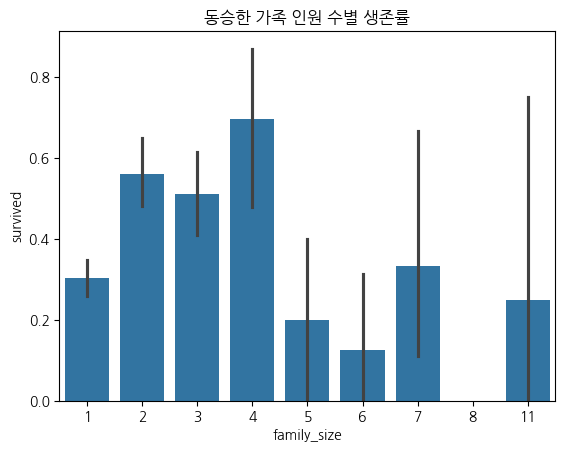

In [153]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [154]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [155]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [156]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [157]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [158]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


#### has_cabin 컬럼

In [159]:
print(f"before : {train.shape}, {test.shape}, {ori_te.shape}")

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(f"after : {train.shape}, {test.shape}, {ori_te.shape}")

before : (732, 19), (184, 19), (393, 18)
after : (732, 19), (184, 19), (393, 18)


In [160]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def get_cols_cleaning(p_pd_list: list) -> list:
    """
    주어진 데이터프레임 리스트에서 결측치가 있는 컬럼을 추출하여 반환
    """
    cols_cleaning = []
    for df in p_pd_list:
        tmp = df.isnull().sum()
        cols_cleaning += list(tmp[tmp > 0].index)

    cols_cleaning = list(set(cols_cleaning))
    print(f'결측치 처리 대상 컬럼: {cols_cleaning}')
    return cols_cleaning

def add_cols_cleaning(p_train: pd.DataFrame, p_test: pd.DataFrame, p_ori_te: pd.DataFrame) -> None:
    """
    - 수치형 변수: Train 데이터에서 랜덤 샘플링하여 결측치 대체
    - 범주형 변수: Train 데이터에서 최빈값(mode)으로 결측치 대체
    """
    pd_list = [p_train, p_test, p_ori_te]

    for col in get_cols_cleaning(pd_list):  # 결측치가 있는 컬럼들만 처리
        for df in pd_list:
            if is_numeric_dtype(df[col]):  # 숫자형 결측치 처리
                # Train 데이터에서 결측치가 없는 값들로 랜덤 샘플링
                random_sampling = p_train[col].dropna().sample(df[col].isnull().sum(), replace=True)
                random_sampling.index = df[df[col].isnull()].index  # 인덱스 매칭
                df.loc[df[col].isnull(), col] = random_sampling  # 기존 컬럼에 채우기
            else:  # 범주형 결측치 처리
                df[col].fillna(p_train[col].mode().values[0], inplace=True)

    print(f'결측치 처리 완료: p_train({p_train.isnull().sum().sum()}), '
          f'p_test({p_test.isnull().sum().sum()}), p_ori_te({p_ori_te.isnull().sum().sum()})')


In [161]:
add_cols_cleaning(train, test, ori_te)

결측치 처리 대상 컬럼: ['embarked', 'fare', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'cabin', 'age']
결측치 처리 완료: p_train(0), p_test(0), p_ori_te(0)


<ipython-input-160-5d49c4898663>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(p_train[col].mode().values[0], inplace=True)
<ipython-input-160-5d49c4898663>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [162]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [163]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [164]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [165]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

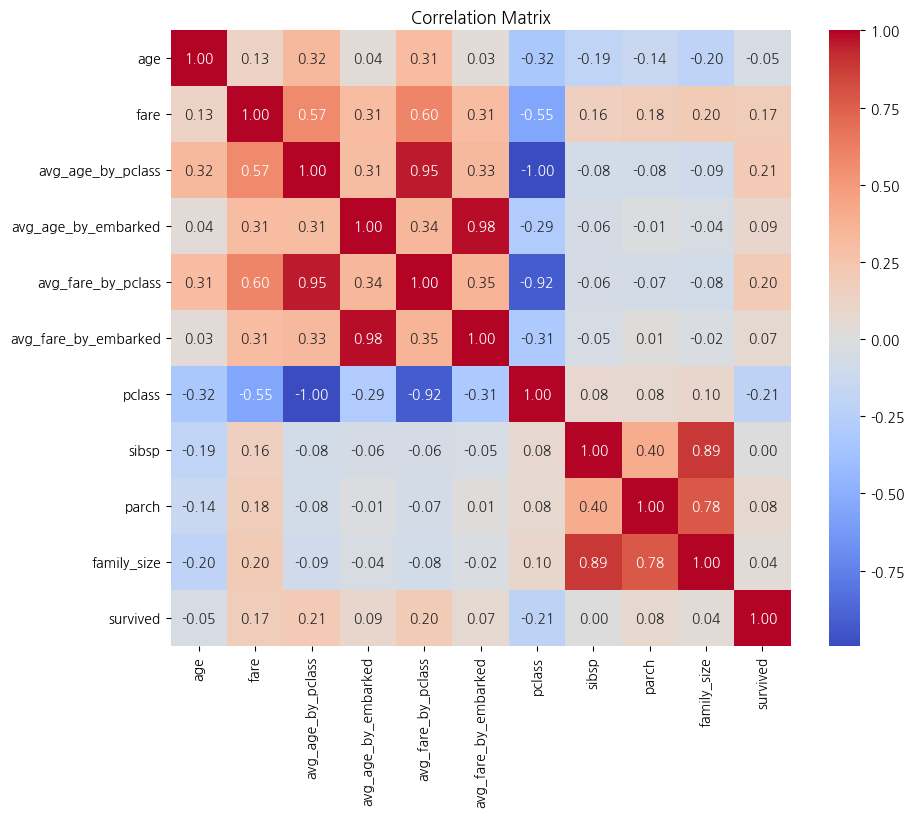

In [166]:
reset_seeds()

# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

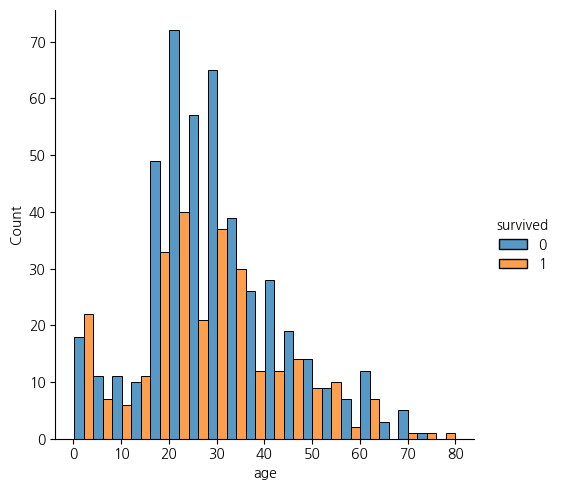

In [167]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [168]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5681818181818182

In [169]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.30434782608695654

In [170]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3648255813953488

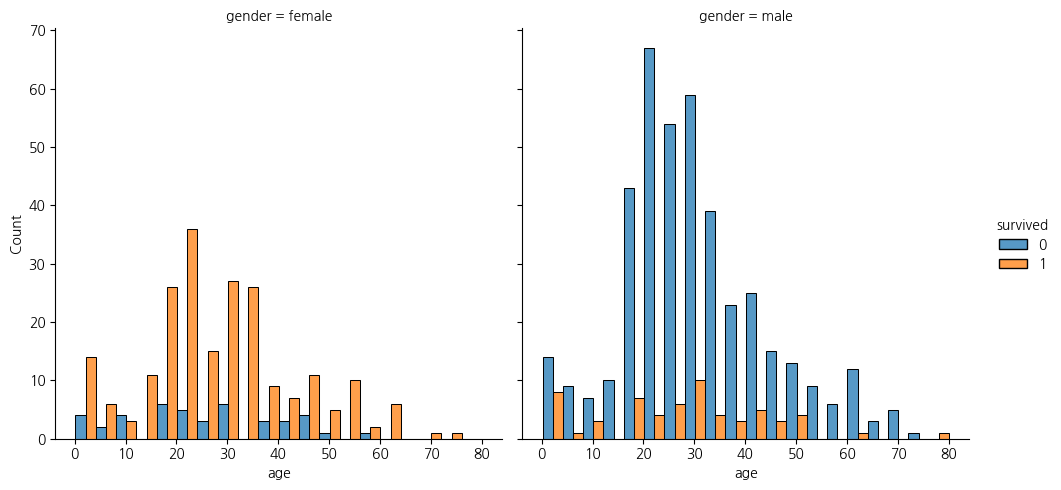

In [171]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [172]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


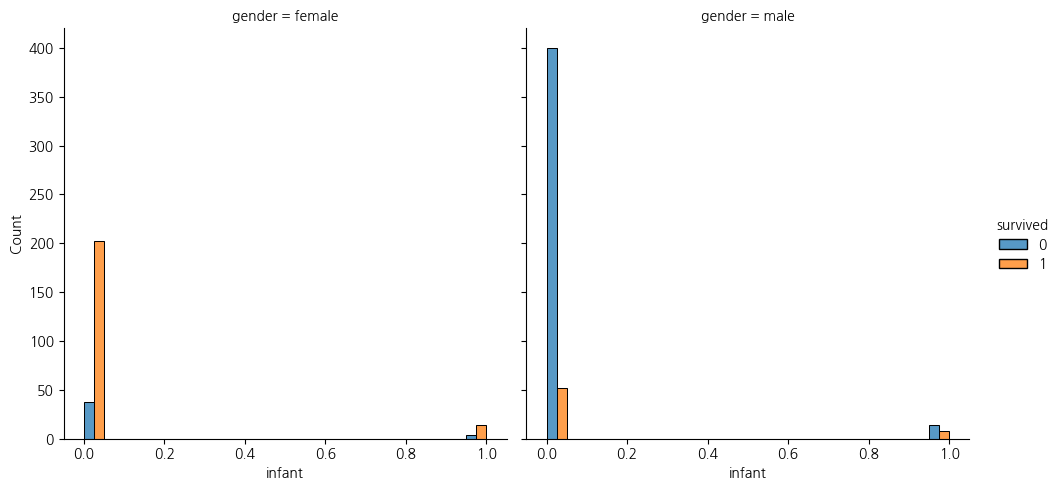

In [173]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [174]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

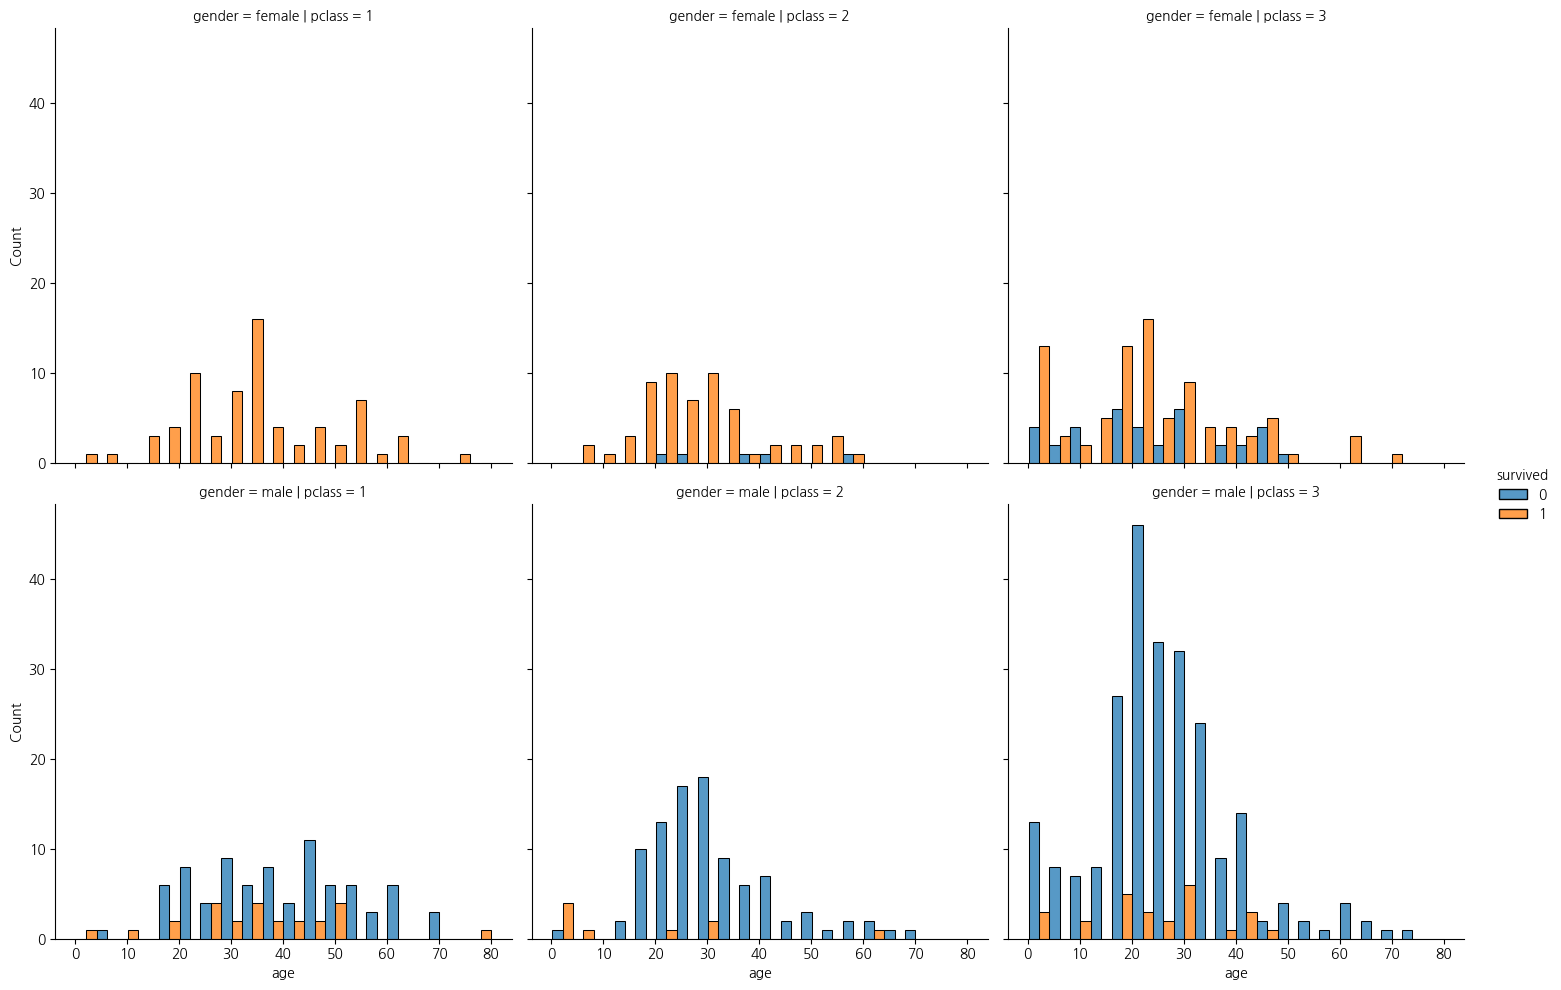

In [175]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [176]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [177]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [178]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [179]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

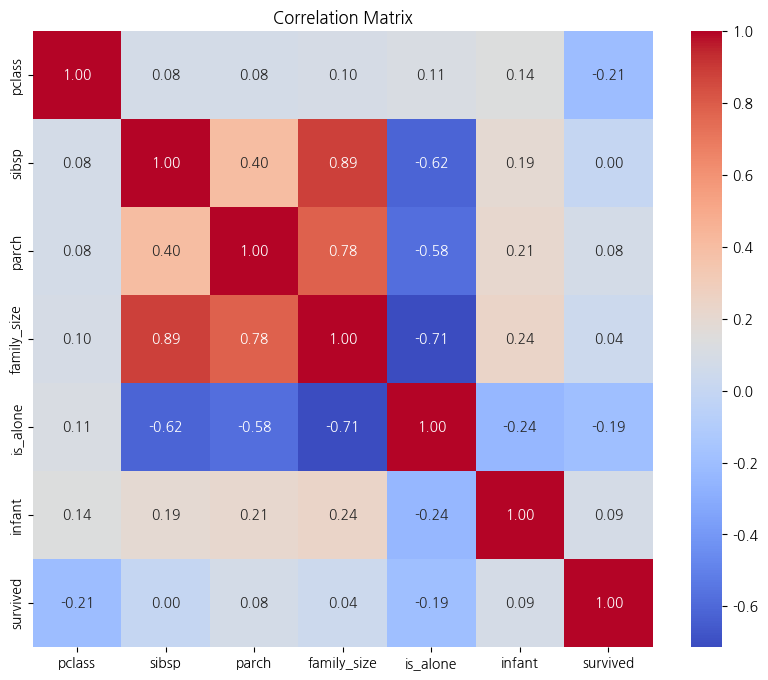

In [180]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [181]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [182]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [183]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [184]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [185]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Scaling

In [186]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23)

In [187]:
reset_seeds()

scaling_cols = ['age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
                'avg_fare_by_embarked', 'family_size']
scaler = StandardScaler()

# train 데이터프레임 스케일링
scaled_train = scaler.fit_transform(train[scaling_cols])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaling_cols)

# train의 스케일링되지 않은 컬럼
not_scaling_cols_train = list(set(train.columns) - set(scaling_cols))
train = pd.concat(
    [train[not_scaling_cols_train].reset_index(drop=True), scaled_train_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# test 데이터프레임 스케일링
scaled_test = scaler.transform(test[scaling_cols])
scaled_test_df = pd.DataFrame(scaled_test, columns=scaling_cols)

# test의 스케일링되지 않은 컬럼
not_scaling_cols_test = list(set(test.columns) - set(scaling_cols))
test = pd.concat(
    [test[not_scaling_cols_test].reset_index(drop=True), scaled_test_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# ori_te 데이터프레임 스케일링
scaled_ori_te = scaler.transform(ori_te[scaling_cols])
scaled_ori_te_df = pd.DataFrame(scaled_ori_te, columns=scaling_cols)

# ori_te의 스케일링되지 않은 컬럼
not_scaling_cols_ori_te = list(set(ori_te.columns) - set(scaling_cols))
ori_te = pd.concat(
    [ori_te[not_scaling_cols_ori_te].reset_index(drop=True), scaled_ori_te_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# 결측치 확인 및 결과 확인
print(f'{train.isnull().sum().sum()}, {test.isnull().sum().sum()}, {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0, 0, 0


((732, 23), (184, 23), (393, 22))

### Data Encoding (여기서는 진행 X)
- 분리만

In [188]:
train.columns, len(train.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23)

In [189]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   sibsp                 732 non-null    int64  
 2   infant                732 non-null    int64  
 3   has_cabin             732 non-null    int64  
 4   pclass                732 non-null    int64  
 5   infant_family_size    732 non-null    object 
 6   gender                732 non-null    object 
 7   embarked              732 non-null    object 
 8   survived              732 non-null    int64  
 9   gender_pclass         732 non-null    object 
 10  gender_infant         732 non-null    object 
 11  pclass_family_size    732 non-null    object 
 12  infant_pclass         732 non-null    object 
 13  pclass_is_alone       732 non-null    object 
 14  is_alone              732 non-null    int64  
 15  parch                 7

In [190]:
train.select_dtypes(include=np.number)

,passengerid,sibsp,infant,has_cabin,pclass,survived,is_alone,parch,age,fare,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
0,914,0,0,0,3,1,1,0,-0.789622,-0.514795,-0.817102,-0.614033,-0.638555,-1.185388,-0.566752
1,805,4,0,0,3,0,0,2,-1.604238,0.012145,-0.817102,-0.484440,-0.638555,-0.399678,3.415925
2,255,1,1,0,3,1,0,1,-1.943661,-0.415190,-0.817102,-0.484440,-0.638555,-0.399678,0.760807
3,769,0,0,0,3,0,1,0,2.774320,-0.514421,-0.817102,-0.614033,-0.638555,-1.185388,-0.566752
4,527,0,0,0,3,0,1,0,0.364416,-0.528411,-0.817102,-0.484440,-0.638555,-0.399678,-0.566752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,403,0,1,0,3,1,0,2,-1.943661,-0.335541,-0.817102,2.002093,-0.638555,1.953991,0.760807
728,824,0,0,0,3,0,1,0,0.296532,-0.507706,-0.817102,-0.484440,-0.638555,-0.399678,-0.566752
729,879,0,0,0,3,0,0,2,-1.332700,-0.147336,-0.817102,-0.484440,-0.638555,-0.399678,0.760807
730,214,0,0,1,1,0,1,0,-0.382315,1.084863,1.629847,2.002093,1.767622,1.953991,-0.566752


In [191]:
train.select_dtypes(exclude=np.number)

,infant_family_size,gender,embarked,gender_pclass,gender_infant,pclass_family_size,infant_pclass,pclass_is_alone
0,0_1,female,Q,female_3,female_0,3_1,0_3,3_1
1,0_7,female,S,female_3,female_0,3_7,0_3,3_0
2,1_3,female,S,female_3,female_1,3_3,1_3,3_0
3,0_1,male,Q,male_3,male_0,3_1,0_3,3_1
4,0_1,male,S,male_3,male_0,3_1,0_3,3_1
...,...,...,...,...,...,...,...,...
727,1_3,female,C,female_3,female_1,3_3,1_3,3_0
728,0_1,male,S,male_3,male_0,3_1,0_3,3_1
729,0_3,female,S,female_3,female_0,3_3,0_3,3_0
730,0_1,male,C,male_1,male_0,1_1,0_1,1_1


In [192]:
train.columns, len(train.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23)

In [193]:
# 범주형 컬럼 리스트
enc_cols = ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender',
                    'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin']

# 수치형 컬럼들
normal_cols = list(set(train.columns) - set(enc_cols)- {'survived'})

print(f"범주형 컬럼들 : {enc_cols} / 수치형 컬럼들 : {normal_cols}")
print(f"범주형 컬럼들 개수: {len(enc_cols)} / 수치형 컬럼들 개수 : {len(normal_cols)}")

범주형 컬럼들 : ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender', 'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin'] / 수치형 컬럼들 : ['passengerid', 'sibsp', 'avg_age_by_pclass', 'infant', 'avg_fare_by_pclass', 'fare', 'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'is_alone', 'parch', 'age']
범주형 컬럼들 개수: 10 / 수치형 컬럼들 개수 : 12


In [194]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'survived', 'gender_pclass',
        'gender_infant', 'pclass_family_size', 'infant_pclass',
        'pclass_is_alone', 'is_alone', 'parch', 'age', 'fare',
        'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
        'avg_fare_by_embarked', 'family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'sibsp', 'infant', 'has_cabin', 'pclass',
        'infant_family_size', 'gender', 'embarked', 'gender_pclass',
        'gender_in

### 범주형 컬럼과 스케일링한 컬럼들을 합치기

In [195]:
reset_seeds()
print(f'before: {train.shape}, {test.shape}, {ori_te.shape}')

# train, test, ori_te 데이터에서 해당 컬럼들을 범주형으로 변환
for df in [train, test, ori_te]:
    df[enc_cols] = df[enc_cols].astype('category')

# 스케일링된 수치형 컬럼 + 범주형 컬럼 합치기
train = pd.concat([train[enc_cols].reset_index(drop=True), train[normal_cols + ['survived']].reset_index(drop=True)], axis=1)
test = pd.concat([test[enc_cols].reset_index(drop=True), test[normal_cols + ['survived']].reset_index(drop=True)], axis=1)
ori_te = pd.concat([ori_te[enc_cols].reset_index(drop=True), ori_te[normal_cols].reset_index(drop=True)], axis=1)

# 결과 출력
print(f'after: {train.shape}, {test.shape}, {ori_te.shape}')
train.head()

before: (732, 23), (184, 23), (393, 22)
after: (732, 23), (184, 23), (393, 22)


,pclass,gender_infant,pclass_family_size,infant_pclass,gender,infant_family_size,embarked,gender_pclass,pclass_is_alone,has_cabin,...,infant,avg_fare_by_pclass,fare,family_size,avg_age_by_embarked,avg_fare_by_embarked,is_alone,parch,age,survived
0,3,female_0,3_1,0_3,female,0_1,Q,female_3,3_1,0,...,0,-0.638555,-0.514795,-0.566752,-0.614033,-1.185388,1,0,-0.789622,1
1,3,female_0,3_7,0_3,female,0_7,S,female_3,3_0,0,...,0,-0.638555,0.012145,3.415925,-0.484440,-0.399678,0,2,-1.604238,0
2,3,female_1,3_3,1_3,female,1_3,S,female_3,3_0,0,...,1,-0.638555,-0.415190,0.760807,-0.484440,-0.399678,0,1,-1.943661,1
3,3,male_0,3_1,0_3,male,0_1,Q,male_3,3_1,0,...,0,-0.638555,-0.514421,-0.566752,-0.614033,-1.185388,1,0,2.774320,0
4,3,male_0,3_1,0_3,male,0_1,S,male_3,3_1,0,...,0,-0.638555,-0.528411,-0.566752,-0.484440,-0.399678,1,0,0.364416,0


## Training

In [196]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [197]:
reset_seeds()

y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((732, 22), (732,), (184, 22), (184,))

In [198]:
# reset_seeds()

# model_name = 'model_cat_V2'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'iterations': list(range(500, 1501, 250)),  # 500~1500 반복
#     'depth': list(range(4, 10)),  # 트리 깊이 4~10
#     'learning_rate': [0.01, 0.05, 0.1],  # 학습률
#     'l2_leaf_reg': [1, 5, 10],  # L2 정규화 강도
#     'boosting_type': ['Ordered', 'Plain'],  # 부스팅 방식
#     'random_seed': [42]  # 랜덤 시드 고정 (재현 가능성)
# }

# # 범주형 컬럼 리스트
# cat_features = enc_cols

# # 범주형 컬럼을 category 형식으로 변환 (메모리 절약)
# X_tr[cat_features] = X_tr[cat_features].astype('category')
# X_te[cat_features] = X_te[cat_features].astype('category')

# # CatBoost 모델 초기화
# # model_cat_V2 = CatBoostClassifier(random_seed=args.random_seed, task_type="GPU")
# model_cat_V2 = CatBoostClassifier(random_seed=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_cat_V2, param_distributions=param_dist,
#     n_iter=50,
#     cv=5,
#     scoring='roc_auc', random_state=42,
#     n_jobs=-1,
#     verbose=2
# )


# random_search.fit(X_tr, y_tr, cat_features=cat_features, early_stopping_rounds=50)

In [199]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [200]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_cat_V2_best = CatBoostClassifier(**parameters)
# print(f'{model_cat_V2_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_cat_V2_best.fit(X_tr, y_tr, cat_features=cat_features)

In [201]:
reset_seeds()

model_name = 'model_cat_V2'

parameters = {
    'random_seed': 42,
    'learning_rate': 0.01,
    'l2_leaf_reg': 1,
    'iterations': 1500,
    'depth': 8,
    'boosting_type': 'Ordered',
    'verbose' : 100
}

# 범주형 컬럼 리스트
cat_features = enc_cols

# 범주형 컬럼을 category 형식으로 변환 (메모리 절약)
X_tr[cat_features] = X_tr[cat_features].astype('category')
X_te[cat_features] = X_te[cat_features].astype('category')

# CatBoost 모델 초기화
# model_cat_V2 = CatBoostClassifier(random_seed=args.random_seed, task_type="GPU")
model_cat_V2 = CatBoostClassifier(**parameters)

model_cat_V2.fit(X_tr, y_tr, cat_features=cat_features, verbose=100)

0:	learn: 0.6843694	total: 30.3ms	remaining: 45.5s
100:	learn: 0.3942454	total: 3.04s	remaining: 42.1s
200:	learn: 0.3439213	total: 4.82s	remaining: 31.2s
300:	learn: 0.3264386	total: 6.32s	remaining: 25.2s
400:	learn: 0.3160964	total: 7.85s	remaining: 21.5s
500:	learn: 0.3041686	total: 9.85s	remaining: 19.6s
600:	learn: 0.2945510	total: 11.5s	remaining: 17.3s
700:	learn: 0.2842730	total: 14.3s	remaining: 16.3s
800:	learn: 0.2706685	total: 18.2s	remaining: 15.9s
900:	learn: 0.2528116	total: 22.6s	remaining: 15s
1000:	learn: 0.2351433	total: 27.9s	remaining: 13.9s
1100:	learn: 0.2197748	total: 34.2s	remaining: 12.4s
1200:	learn: 0.2054014	total: 39.1s	remaining: 9.74s
1300:	learn: 0.1910277	total: 46.1s	remaining: 7.05s
1400:	learn: 0.1809790	total: 51.1s	remaining: 3.61s
1499:	learn: 0.1720184	total: 57.5s	remaining: 0us


## Evaluation (평가)

In [202]:
reset_seeds()

# CatBoost 모델
# - Train data
score_tr_cat = model_cat_V2.score(X_tr, y_tr)
# - Test data
score_te_cat = model_cat_V2.score(X_te, y_te)

print(f'{model_cat_V2} : {score_tr_cat}, {score_te_cat}')

<catboost.core.CatBoostClassifier object at 0x78f3dd60a710> : 0.8989071038251366, 0.875


### AUC 점수

In [203]:
reset_seeds()

y_pred = model_cat_V2.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_cat_V2}: {auc_te}')

<catboost.core.CatBoostClassifier object at 0x78f3dd60a710>: 0.9117794486215538


### 혼동행렬

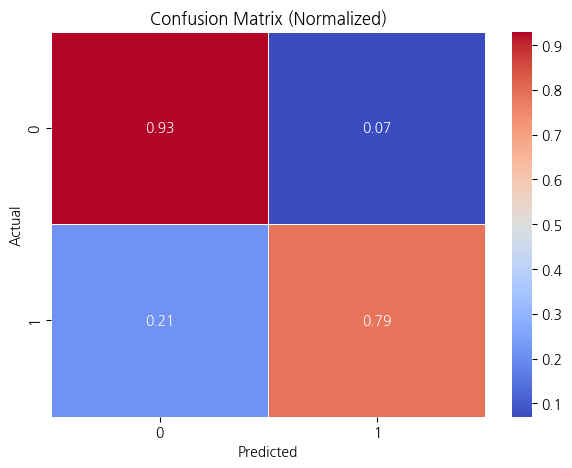

In [204]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_cat_V2.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [205]:
reset_seeds()

ori_te_pred = model_cat_V2.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [206]:
df_feature_importances = pd.DataFrame(model_cat_V2.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


,index,0
0,gender_pclass,19.388905
1,gender_infant,14.567020
2,passengerid,12.213655
3,fare,8.497208
4,infant_pclass,6.041653
5,embarked,5.143156
6,gender,4.206961
7,age,3.989141
8,pclass_is_alone,3.451846
9,pclass_family_size,3.433899


### 결과 정리

In [207]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_cat,
        'score_te': score_te_cat,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [208]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
2,model_cat_V2,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.898907,0.875000,0.911779,"[0.9507334075002624, 0.9677577181532617, 0.959...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28
1,model_cat_V1,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.903005,0.869565,0.911654,"[0.9566383013903034, 0.9289832713644142, 0.956...",22,"[gender_pclass, gender_infant, passengerid, ag...",2025-02-12 13:31:28
0,model_cat_V0,"{'iterations': 1500, 'depth': 8, 'learning_rat...",0.919399,0.875000,0.905764,"[0.9846089897632051, 0.9596377785533127, 0.988...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28


# model_CatBoost_V3 (random search 진행) - 0212_6(1)
- V1과의 차이 : 결측치 처리가 다름
- V2와의 차이 : V2는 인코딩 안함, V3는 인코딩 함

## Train & Test Split

In [209]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [210]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [211]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [212]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [213]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [214]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [215]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [216]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [217]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [218]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [219]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


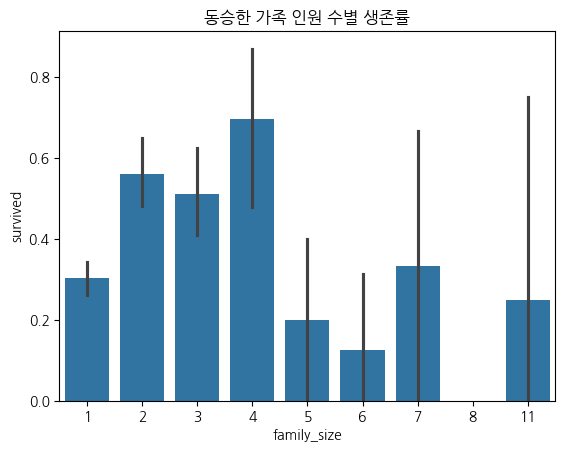

In [220]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [221]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [222]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [223]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [224]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [225]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


#### has_cabin 컬럼

In [226]:
print(f"before : {train.shape}, {test.shape}, {ori_te.shape}")

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(f"after : {train.shape}, {test.shape}, {ori_te.shape}")

before : (732, 19), (184, 19), (393, 18)
after : (732, 19), (184, 19), (393, 18)


In [227]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def get_cols_cleaning(p_pd_list: list) -> list:
    """
    주어진 데이터프레임 리스트에서 결측치가 있는 컬럼을 추출하여 반환
    """
    cols_cleaning = []
    for df in p_pd_list:
        tmp = df.isnull().sum()
        cols_cleaning += list(tmp[tmp > 0].index)

    cols_cleaning = list(set(cols_cleaning))
    print(f'결측치 처리 대상 컬럼: {cols_cleaning}')
    return cols_cleaning

def add_cols_cleaning(p_train: pd.DataFrame, p_test: pd.DataFrame, p_ori_te: pd.DataFrame) -> None:
    """
    - 수치형 변수: Train 데이터에서 랜덤 샘플링하여 결측치 대체
    - 범주형 변수: Train 데이터에서 최빈값(mode)으로 결측치 대체
    """
    pd_list = [p_train, p_test, p_ori_te]

    for col in get_cols_cleaning(pd_list):  # 결측치가 있는 컬럼들만 처리
        for df in pd_list:
            if is_numeric_dtype(df[col]):  # 숫자형 결측치 처리
                # Train 데이터에서 결측치가 없는 값들로 랜덤 샘플링
                random_sampling = p_train[col].dropna().sample(df[col].isnull().sum(), replace=True)
                random_sampling.index = df[df[col].isnull()].index  # 인덱스 매칭
                df.loc[df[col].isnull(), col] = random_sampling  # 기존 컬럼에 채우기
            else:  # 범주형 결측치 처리
                df[col].fillna(p_train[col].mode().values[0], inplace=True)

    print(f'결측치 처리 완료: p_train({p_train.isnull().sum().sum()}), '
          f'p_test({p_test.isnull().sum().sum()}), p_ori_te({p_ori_te.isnull().sum().sum()})')


In [228]:
add_cols_cleaning(train, test, ori_te)

결측치 처리 대상 컬럼: ['embarked', 'fare', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'cabin', 'age']
결측치 처리 완료: p_train(0), p_test(0), p_ori_te(0)


<ipython-input-227-5d49c4898663>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(p_train[col].mode().values[0], inplace=True)
<ipython-input-227-5d49c4898663>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [229]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [230]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [231]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [232]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

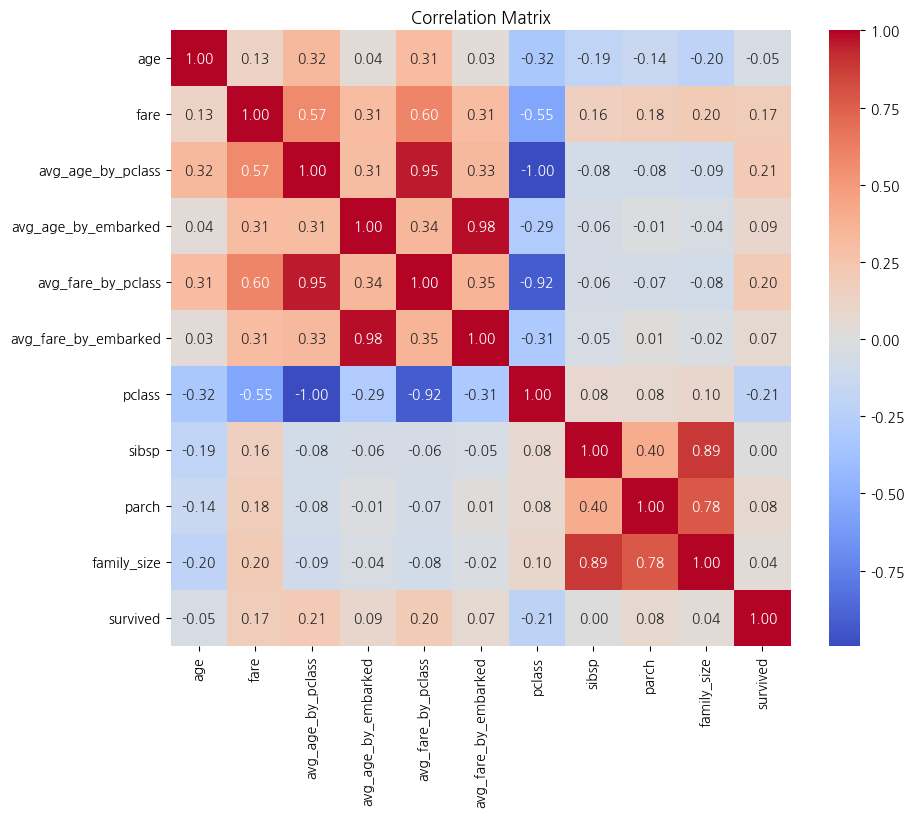

In [233]:
reset_seeds()

# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

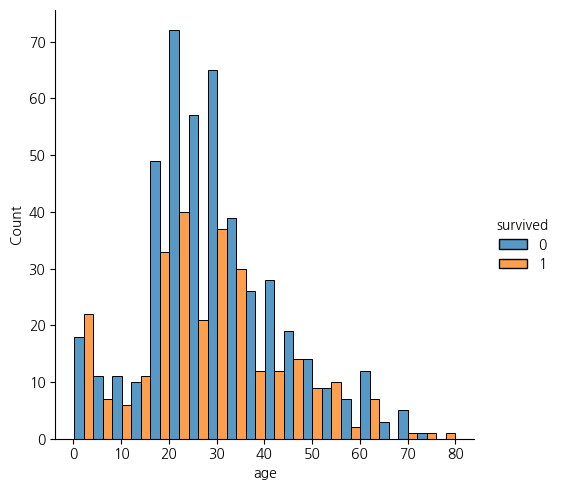

In [234]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [235]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5681818181818182

In [236]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.30434782608695654

In [237]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3648255813953488

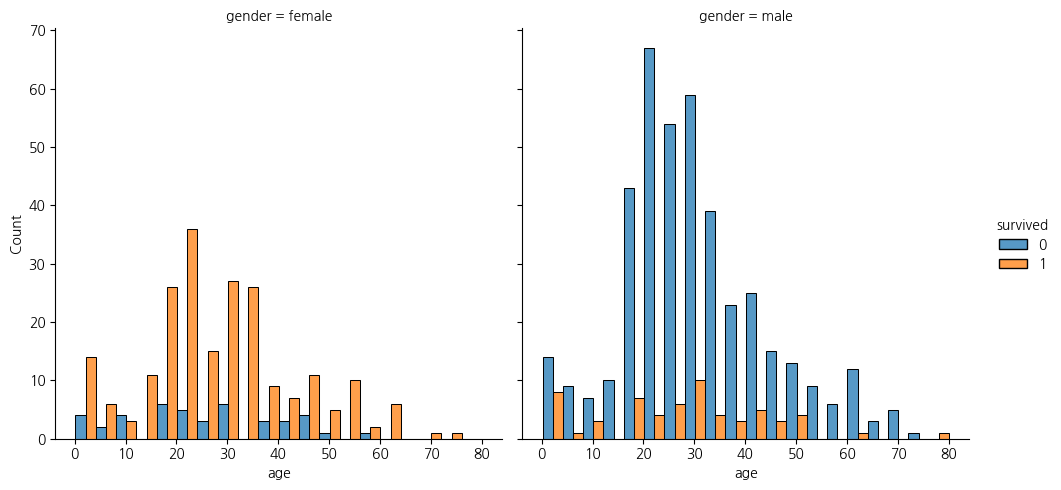

In [238]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [239]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


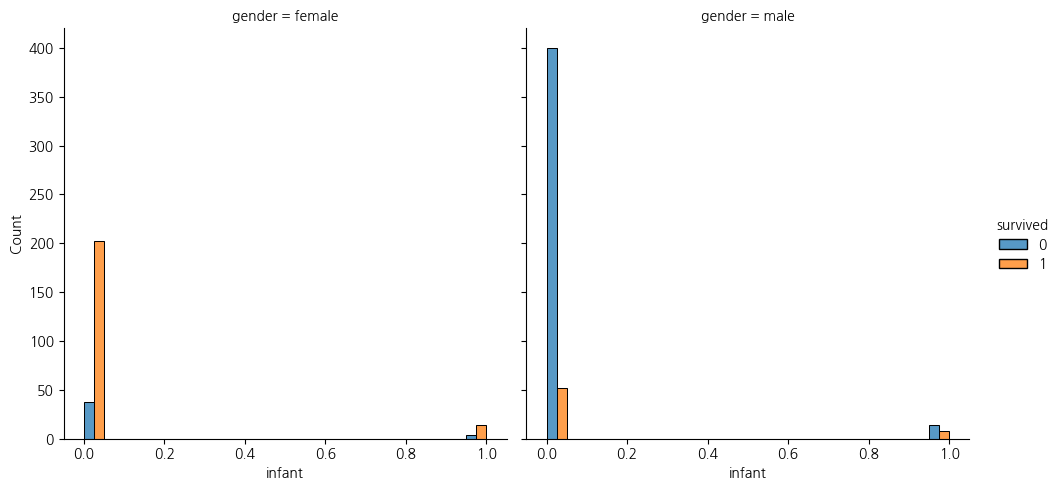

In [240]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [241]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

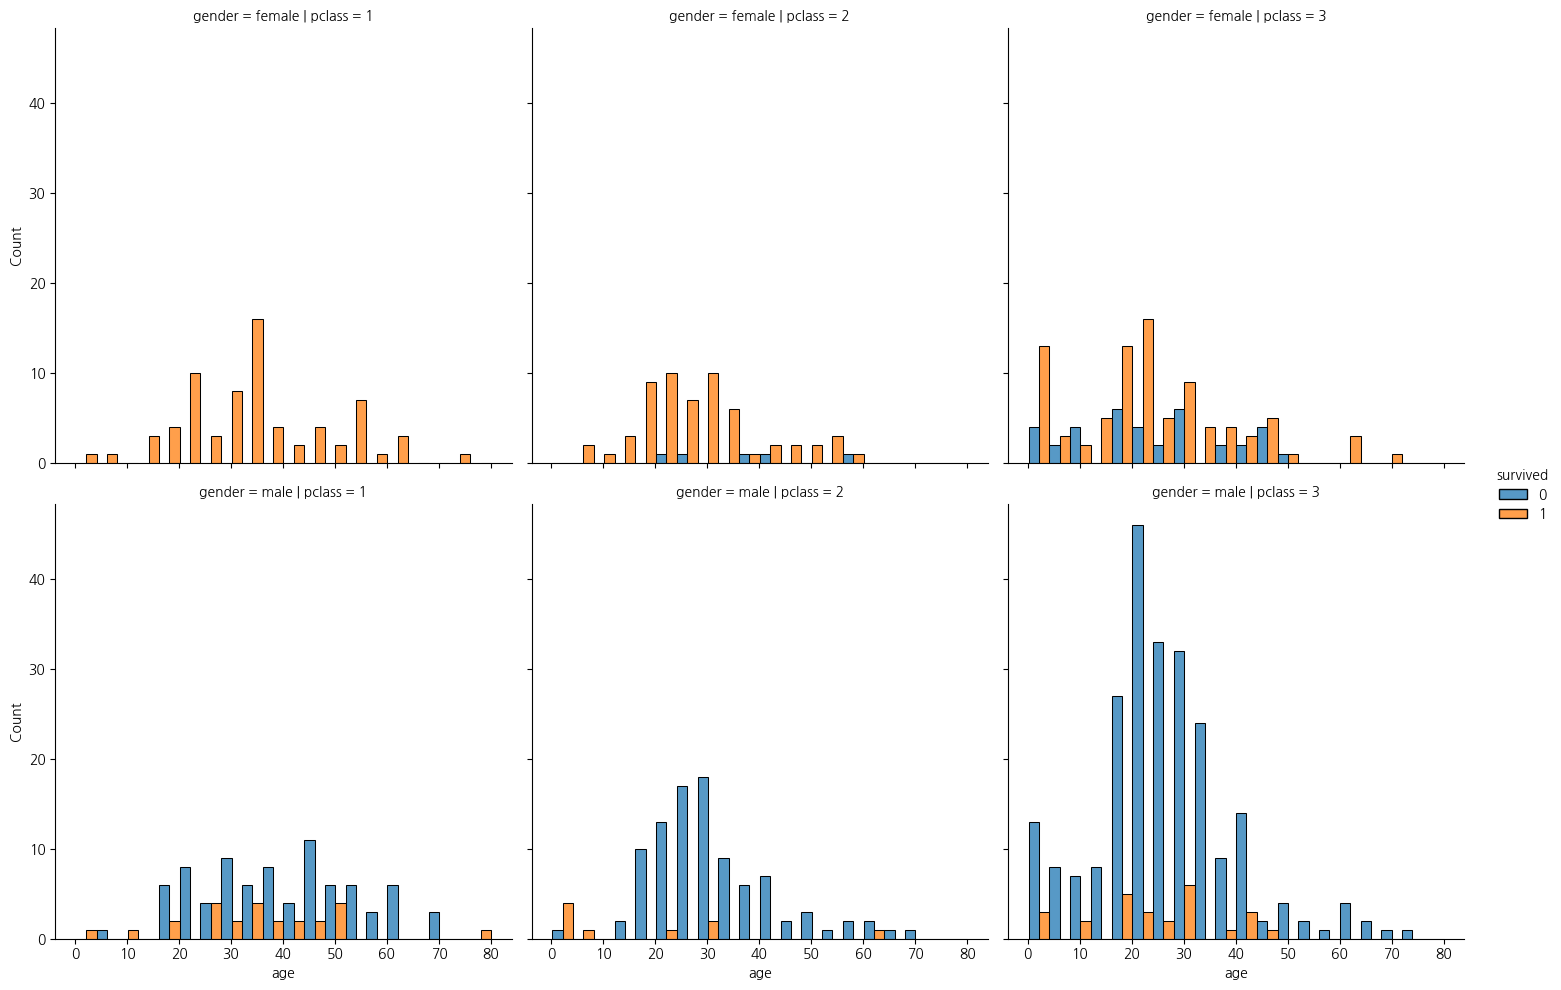

In [242]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [243]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [244]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [245]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [246]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

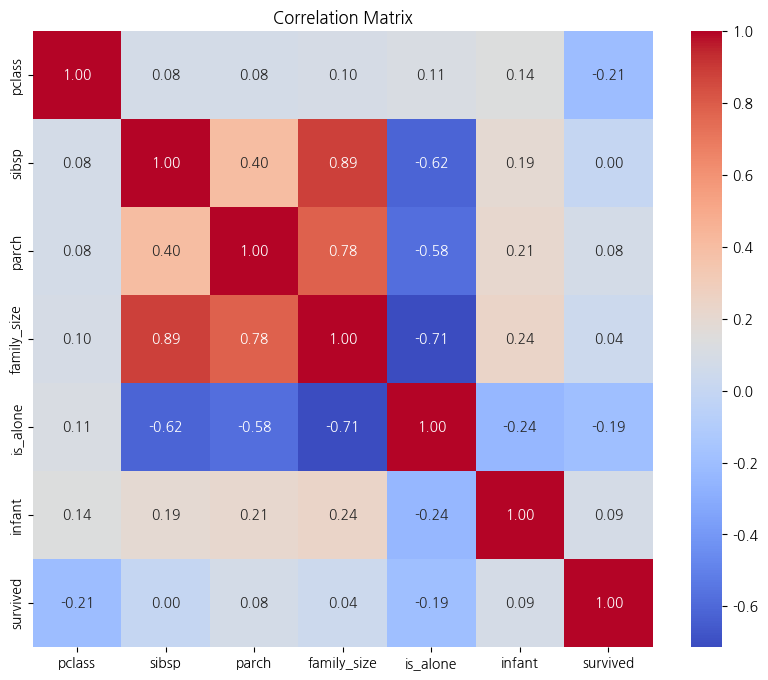

In [247]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [248]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [249]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [250]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [251]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,18.0,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.0,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.0,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.5,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.0,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [252]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Scaling

In [253]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23)

In [254]:
# 범주형 컬럼 리스트
enc_cols = ['pclass', 'gender', 'embarked', 'has_cabin', 'infant',
            'gender_infant', 'gender_pclass', 'infant_pclass',
            'infant_family_size', 'pclass_is_alone', 'pclass_family_size']

# 수치형 컬럼들 (train.columns에서 'survived'와 enc_cols를 제외한 나머지)
normal_cols = list(set(train.columns) - set(enc_cols) - {'survived'})

# 결과 출력
print(f"범주형 컬럼들 : {enc_cols} / 수치형 컬럼들 : {normal_cols}")
print(f"범주형 컬럼들 개수: {len(enc_cols)} / 수치형 컬럼들 개수 : {len(normal_cols)}")


범주형 컬럼들 : ['pclass', 'gender', 'embarked', 'has_cabin', 'infant', 'gender_infant', 'gender_pclass', 'infant_pclass', 'infant_family_size', 'pclass_is_alone', 'pclass_family_size'] / 수치형 컬럼들 : ['passengerid', 'sibsp', 'avg_age_by_pclass', 'avg_fare_by_pclass', 'fare', 'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'is_alone', 'parch', 'age']
범주형 컬럼들 개수: 11 / 수치형 컬럼들 개수 : 11


In [255]:
reset_seeds()

scaler = StandardScaler()

# train 데이터프레임 스케일링
scaled_train = scaler.fit_transform(train[normal_cols])
scaled_train_df = pd.DataFrame(scaled_train, columns=normal_cols)

# train의 스케일링되지 않은 컬럼
not_scaling_cols_train = list(set(train.columns) - set(normal_cols))
train = pd.concat(
    [train[not_scaling_cols_train].reset_index(drop=True), scaled_train_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# test 데이터프레임 스케일링
scaled_test = scaler.transform(test[normal_cols])
scaled_test_df = pd.DataFrame(scaled_test, columns=normal_cols)

# test의 스케일링되지 않은 컬럼
not_scaling_cols_test = list(set(test.columns) - set(normal_cols))
test = pd.concat(
    [test[not_scaling_cols_test].reset_index(drop=True), scaled_test_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# ori_te 데이터프레임 스케일링
scaled_ori_te = scaler.transform(ori_te[normal_cols])
scaled_ori_te_df = pd.DataFrame(scaled_ori_te, columns=normal_cols)

# ori_te의 스케일링되지 않은 컬럼
not_scaling_cols_ori_te = list(set(ori_te.columns) - set(normal_cols))
ori_te = pd.concat(
    [ori_te[not_scaling_cols_ori_te].reset_index(drop=True), scaled_ori_te_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# 결측치 확인 및 결과 확인
print(f'{train.isnull().sum().sum()}, {test.isnull().sum().sum()}, {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape


0, 0, 0


((732, 23), (184, 23), (393, 22))

### Data Encoding

In [256]:
train.columns, len(train.columns)

(Index(['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender',
        'embarked', 'survived', 'gender_pclass', 'gender_infant',
        'pclass_family_size', 'infant_pclass', 'pclass_is_alone', 'passengerid',
        'sibsp', 'avg_age_by_pclass', 'avg_fare_by_pclass', 'fare',
        'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked',
        'is_alone', 'parch', 'age'],
       dtype='object'),
 23)

In [257]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   infant                732 non-null    int64  
 1   has_cabin             732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   infant_family_size    732 non-null    object 
 4   gender                732 non-null    object 
 5   embarked              732 non-null    object 
 6   survived              732 non-null    int64  
 7   gender_pclass         732 non-null    object 
 8   gender_infant         732 non-null    object 
 9   pclass_family_size    732 non-null    object 
 10  infant_pclass         732 non-null    object 
 11  pclass_is_alone       732 non-null    object 
 12  passengerid           732 non-null    float64
 13  sibsp                 732 non-null    float64
 14  avg_age_by_pclass     732 non-null    float64
 15  avg_fare_by_pclass    7

In [258]:
# train, test, ori_te 데이터에서 해당 컬럼들을 범주형으로 변환
for df in [train, test, ori_te]:
    df[enc_cols] = df[enc_cols].astype(str)

train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender',
        'embarked', 'survived', 'gender_pclass', 'gender_infant',
        'pclass_family_size', 'infant_pclass', 'pclass_is_alone', 'passengerid',
        'sibsp', 'avg_age_by_pclass', 'avg_fare_by_pclass', 'fare',
        'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked',
        'is_alone', 'parch', 'age'],
       dtype='object'),
 23,
 Index(['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender',
        'embarked', 'survived', 'gender_pclass', 'gender_infant',
        'pclass_family_size', 'infant_pclass', 'pclass_is_alone', 'passengerid',
        'sibsp', 'avg_age_by_pclass', 'avg_fare_by_pclass', 'fare',
        'family_size', 'avg_age_by_embarked', 'avg_fare_by_embarked',
        'is_alone', 'parch', 'age'],
       dtype='object'),
 23,
 Index(['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender',
        'embarked', 'gender_pclass', 'gender_infant', 'pclass_family_size',
   

In [259]:
print(f"train : {list(train.select_dtypes(exclude=np.number))} / {len(list(train.select_dtypes(exclude=np.number)))}")
print(f"test : {list(test.select_dtypes(exclude=np.number))} / {len(list(test.select_dtypes(exclude=np.number)))}")
print(f"ori_te : {list(ori_te.select_dtypes(exclude=np.number))} / {len(list(ori_te.select_dtypes(exclude=np.number)))}")


train : ['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender', 'embarked', 'gender_pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'pclass_is_alone'] / 11
test : ['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender', 'embarked', 'gender_pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'pclass_is_alone'] / 11
ori_te : ['infant', 'has_cabin', 'pclass', 'infant_family_size', 'gender', 'embarked', 'gender_pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'pclass_is_alone'] / 11


In [260]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# train 데이터 원핫 인코딩
encoded_train = onehot_encoder.fit_transform(train[enc_cols])
encoded_train_df = pd.DataFrame(encoded_train, columns=onehot_encoder.get_feature_names_out(enc_cols))

# test 데이터 원핫 인코딩
encoded_test = onehot_encoder.transform(test[enc_cols])
encoded_test_df = pd.DataFrame(encoded_test, columns=onehot_encoder.get_feature_names_out(enc_cols))

# ori_te 데이터 원핫 인코딩
encoded_ori_te = onehot_encoder.transform(ori_te[enc_cols])
encoded_ori_te_df = pd.DataFrame(encoded_ori_te, columns=onehot_encoder.get_feature_names_out(enc_cols))

# 기존 데이터에서 범주형 컬럼 제거 후 원핫 인코딩된 컬럼 추가
train = pd.concat([train.drop(columns=enc_cols).reset_index(drop=True), encoded_train_df.reset_index(drop=True)], axis=1)
test = pd.concat([test.drop(columns=enc_cols).reset_index(drop=True), encoded_test_df.reset_index(drop=True)], axis=1)
ori_te = pd.concat([ori_te.drop(columns=enc_cols).reset_index(drop=True), encoded_ori_te_df.reset_index(drop=True)], axis=1)

# 결과 확인
print(f"train shape: {train.shape}, test shape: {test.shape}, ori_te shape: {ori_te.shape}")
print(f"train : {len(train.columns)}, test : {len(test.columns)}, ori_te : {len(ori_te.columns)}")


train shape: (732, 84), test shape: (184, 84), ori_te shape: (393, 83)
train : 84, test : 84, ori_te : 83


In [261]:
# 원핫 인코딩 후 생성된 새로운 컬럼 리스트로 업데이트
enc_cols = list(onehot_encoder.get_feature_names_out(enc_cols))

print(f"업데이트된 enc_cols : {enc_cols}")

업데이트된 enc_cols : ['pclass_1', 'pclass_2', 'pclass_3', 'gender_female', 'gender_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'has_cabin_0', 'has_cabin_1', 'infant_0', 'infant_1', 'gender_infant_female_0', 'gender_infant_female_1', 'gender_infant_male_0', 'gender_infant_male_1', 'gender_pclass_female_1', 'gender_pclass_female_2', 'gender_pclass_female_3', 'gender_pclass_male_1', 'gender_pclass_male_2', 'gender_pclass_male_3', 'infant_pclass_0_1', 'infant_pclass_0_2', 'infant_pclass_0_3', 'infant_pclass_1_1', 'infant_pclass_1_2', 'infant_pclass_1_3', 'infant_family_size_0_1', 'infant_family_size_0_11', 'infant_family_size_0_2', 'infant_family_size_0_3', 'infant_family_size_0_4', 'infant_family_size_0_5', 'infant_family_size_0_6', 'infant_family_size_0_7', 'infant_family_size_0_8', 'infant_family_size_1_1', 'infant_family_size_1_2', 'infant_family_size_1_3', 'infant_family_size_1_4', 'infant_family_size_1_5', 'infant_family_size_1_6', 'infant_family_size_1_7', 'infant_family_size_1_8',

In [262]:
# train, test, ori_te 데이터에서 해당 컬럼들을 범주형으로 변환
for df in [train, test, ori_te]:
    df[enc_cols] = df[enc_cols].astype(str)

train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['survived', 'passengerid', 'sibsp', 'avg_age_by_pclass',
        'avg_fare_by_pclass', 'fare', 'family_size', 'avg_age_by_embarked',
        'avg_fare_by_embarked', 'is_alone', 'parch', 'age', 'pclass_1',
        'pclass_2', 'pclass_3', 'gender_female', 'gender_male', 'embarked_C',
        'embarked_Q', 'embarked_S', 'has_cabin_0', 'has_cabin_1', 'infant_0',
        'infant_1', 'gender_infant_female_0', 'gender_infant_female_1',
        'gender_infant_male_0', 'gender_infant_male_1',
        'gender_pclass_female_1', 'gender_pclass_female_2',
        'gender_pclass_female_3', 'gender_pclass_male_1',
        'gender_pclass_male_2', 'gender_pclass_male_3', 'infant_pclass_0_1',
        'infant_pclass_0_2', 'infant_pclass_0_3', 'infant_pclass_1_1',
        'infant_pclass_1_2', 'infant_pclass_1_3', 'infant_family_size_0_1',
        'infant_family_size_0_11', 'infant_family_size_0_2',
        'infant_family_size_0_3', 'infant_family_size_0_4',
        'infant_family_size_0_5', 'infan

- 이미 스케일링한 결과와 인코딩한 결과가 합쳐짐

## Training

In [263]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [264]:
reset_seeds()

y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((732, 83), (732,), (184, 83), (184,))

In [265]:
reset_seeds()

model_name = 'model_cat_V3'

# 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
param_dist = {
    'iterations': list(range(500, 1501, 250)),  # 500~1500 반복
    'depth': list(range(4, 10)),  # 트리 깊이 4~10
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'l2_leaf_reg': [1, 5, 10],  # L2 정규화 강도
    'boosting_type': ['Ordered', 'Plain'],  # 부스팅 방식
    'random_seed': [42],
    'verbose' : [100]
}

# 범주형 컬럼 리스트
cat_features = enc_cols

# 범주형 컬럼을 category 형식으로 변환 (메모리 절약)
X_tr[cat_features] = X_tr[cat_features].astype('category')
X_te[cat_features] = X_te[cat_features].astype('category')

# CatBoost 모델 초기화
# model_cat_V3 = CatBoostClassifier(random_seed=args.random_seed, task_type="GPU")
model_cat_V3 = CatBoostClassifier(random_seed=args.random_seed)

# 랜덤 서치 실행
random_search = RandomizedSearchCV(
    estimator=model_cat_V3, param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='roc_auc', random_state=42,
    n_jobs=-1,
    verbose=2
)


random_search.fit(X_tr, y_tr, cat_features=cat_features, early_stopping_rounds=50)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0:	learn: 0.6846660	total: 5.2ms	remaining: 2.59s
100:	learn: 0.3847883	total: 173ms	remaining: 681ms
200:	learn: 0.3374115	total: 363ms	remaining: 541ms
300:	learn: 0.3203816	total: 549ms	remaining: 363ms
400:	learn: 0.3099438	total: 724ms	remaining: 179ms
499:	learn: 0.3014452	total: 884ms	remaining: 0us


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x78f3dcaa6f50>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'boosting_type': ['Ordered', 'Plain'],
                                        'depth': [4, 5, 6, 7, 8, 9],
                                        'iterations': [500, 750, 1000, 1250,
                                                       1500],
                                        'l2_leaf_reg': [1, 5, 10],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'random_seed': [42], 'verbose': [100]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [266]:
# 최적의 하이퍼파라미터 출력
parameters = random_search.best_params_
print("Best parameters found: ", parameters)

Best parameters found:  {'verbose': 100, 'random_seed': 42, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 5, 'boosting_type': 'Plain'}


In [267]:
reset_seeds()

# 최적의 파라미터로 새로운 CatBoostClassifier 모델 생성
model_cat_V3_best = CatBoostClassifier(**parameters)
print(f'{model_cat_V3_best} : {X_tr.shape} / {y_tr.shape}')

# 모델 학습
model_cat_V3_best.fit(X_tr, y_tr, cat_features=cat_features)

<catboost.core.CatBoostClassifier object at 0x78f3df13f790> : (732, 83) / (732,)
0:	learn: 0.6846660	total: 1.89ms	remaining: 941ms
100:	learn: 0.3847883	total: 165ms	remaining: 652ms
200:	learn: 0.3374115	total: 336ms	remaining: 500ms
300:	learn: 0.3203816	total: 523ms	remaining: 345ms
400:	learn: 0.3099438	total: 709ms	remaining: 175ms
499:	learn: 0.3014452	total: 873ms	remaining: 0us


In [268]:
# reset_seeds()

# model_name = 'model_cat_V8'

# parameters = {
#     'random_seed': 42,
#     'learning_rate': 0.01,
#     'l2_leaf_reg': 1,
#     'iterations': 1500,
#     'depth': 8,
#     'boosting_type': 'Ordered',
#     'verbose' : 100
# }

# # 범주형 컬럼 리스트
# cat_features = enc_cols

# # 범주형 컬럼을 category 형식으로 변환 (메모리 절약)
# X_tr[cat_features] = X_tr[cat_features].astype('category')
# X_te[cat_features] = X_te[cat_features].astype('category')

# # CatBoost 모델 초기화
# # model_cat_V8 = CatBoostClassifier(random_seed=args.random_seed, task_type="GPU")
# model_cat_V8 = CatBoostClassifier(**parameters)

# model_cat_V8.fit(X_tr, y_tr, cat_features=cat_features, verbose=100)

## Evaluation (평가)

In [269]:
reset_seeds()

# CatBoost 모델
# - Train data
score_tr_cat = model_cat_V3_best.score(X_tr, y_tr)
# - Test data
score_te_cat = model_cat_V3_best.score(X_te, y_te)

print(f'{model_cat_V3_best} : {score_tr_cat}, {score_te_cat}')

<catboost.core.CatBoostClassifier object at 0x78f3df13f790> : 0.8825136612021858, 0.8641304347826086


### AUC 점수

In [270]:
reset_seeds()

y_pred = model_cat_V3_best.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_cat_V3_best}: {auc_te}')

<catboost.core.CatBoostClassifier object at 0x78f3df13f790>: 0.9165413533834585


### 혼동행렬

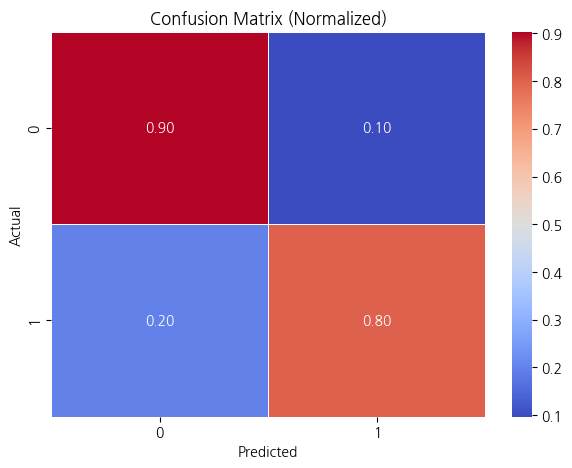

In [271]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_cat_V3_best.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [272]:
reset_seeds()

ori_te_pred = model_cat_V3_best.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [273]:
df_feature_importances = pd.DataFrame(model_cat_V3_best.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(83, 2)


,index,0
0,gender_female,22.245480
1,gender_infant_male_0,18.899018
2,gender_male,17.281659
3,gender_infant_female_0,7.446417
4,fare,4.139176
5,avg_fare_by_pclass,3.487147
6,passengerid,2.744705
7,family_size,2.146949
8,avg_age_by_pclass,2.050581
9,age,2.019107


### 결과 정리

In [274]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_cat,
        'score_te': score_te_cat,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [275]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
3,model_cat_V3,"{'verbose': 100, 'random_seed': 42, 'learning_...",0.882514,0.864130,0.916541,"[0.8559413200142121, 0.8616651335360749, 0.864...",83,"[gender_female, gender_infant_male_0, gender_m...",2025-02-12 13:31:28
2,model_cat_V2,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.898907,0.875000,0.911779,"[0.9507334075002624, 0.9677577181532617, 0.959...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28
1,model_cat_V1,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.903005,0.869565,0.911654,"[0.9566383013903034, 0.9289832713644142, 0.956...",22,"[gender_pclass, gender_infant, passengerid, ag...",2025-02-12 13:31:28
0,model_cat_V0,"{'iterations': 1500, 'depth': 8, 'learning_rat...",0.919399,0.875000,0.905764,"[0.9846089897632051, 0.9596377785533127, 0.988...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28


# Submission

In [276]:
default_submission = pd.read_csv(args.default_submission)
default_submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [281]:
# auc_te 값을 기준으로 내림차순
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
3,model_cat_V3,"{'verbose': 100, 'random_seed': 42, 'learning_...",0.882514,0.864130,0.916541,"[0.8559413200142121, 0.8616651335360749, 0.864...",83,"[gender_female, gender_infant_male_0, gender_m...",2025-02-12 13:31:28
2,model_cat_V2,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.898907,0.875000,0.911779,"[0.9507334075002624, 0.9677577181532617, 0.959...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28
1,model_cat_V1,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.903005,0.869565,0.911654,"[0.9566383013903034, 0.9289832713644142, 0.956...",22,"[gender_pclass, gender_infant, passengerid, ag...",2025-02-12 13:31:28
0,model_cat_V0,"{'iterations': 1500, 'depth': 8, 'learning_rat...",0.919399,0.875000,0.905764,"[0.9846089897632051, 0.9596377785533127, 0.988...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28


In [282]:
# 차이가 작은 것부터 정렬 후, AUC 높은 순 정렬
df_results = pd.DataFrame(args.results).assign(
    # Train과 Test 성능 차이 계산
    score_diff=lambda df: abs(df['score_tr'] - df['score_te'])
).sort_values(by=['score_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff
3,model_cat_V3,"{'verbose': 100, 'random_seed': 42, 'learning_...",0.882514,0.864130,0.916541,"[0.8559413200142121, 0.8616651335360749, 0.864...",83,"[gender_female, gender_infant_male_0, gender_m...",2025-02-12 13:31:28,0.018383
2,model_cat_V2,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.898907,0.875000,0.911779,"[0.9507334075002624, 0.9677577181532617, 0.959...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28,0.023907
1,model_cat_V1,"{'random_seed': 42, 'learning_rate': 0.01, 'l2...",0.903005,0.869565,0.911654,"[0.9566383013903034, 0.9289832713644142, 0.956...",22,"[gender_pclass, gender_infant, passengerid, ag...",2025-02-12 13:31:28,0.033440
0,model_cat_V0,"{'iterations': 1500, 'depth': 8, 'learning_rat...",0.919399,0.875000,0.905764,"[0.9846089897632051, 0.9596377785533127, 0.988...",22,"[gender_pclass, gender_infant, passengerid, fa...",2025-02-12 13:31:28,0.044399


In [283]:
df_results.iloc[0]['ori_te_pred']

array([0.85594132, 0.86166513, 0.86400544, 0.08819581, 0.95328922,
       0.9038859 , 0.11707254, 0.07286575, 0.58923461, 0.09465299,
       0.10206882, 0.07214685, 0.54120545, 0.79900451, 0.09882082,
       0.18620954, 0.19929729, 0.34812791, 0.10356311, 0.06821382,
       0.09611615, 0.06743144, 0.07081674, 0.06446083, 0.10298742,
       0.09570931, 0.20245493, 0.71616674, 0.27799177, 0.11405877,
       0.73734389, 0.73761479, 0.17288922, 0.22960518, 0.20466763,
       0.09354531, 0.88607393, 0.06321316, 0.27097584, 0.11705421,
       0.08785018, 0.9535003 , 0.13665453, 0.96661923, 0.06452038,
       0.06297298, 0.16504216, 0.10443021, 0.09379039, 0.11126941,
       0.71528784, 0.08720591, 0.97370942, 0.09611615, 0.73102546,
       0.86971628, 0.20366289, 0.16474899, 0.0645701 , 0.28615324,
       0.95536605, 0.52894278, 0.86001412, 0.07524646, 0.10426765,
       0.06444102, 0.76116122, 0.84869369, 0.09670652, 0.90514191,
       0.12924723, 0.60700854, 0.73502152, 0.85025123, 0.09027

In [284]:
default_submission['survived'] = df_results.iloc[0]['ori_te_pred']

# 결측값 확인 및 결과 출력
print(f'{default_submission.isnull().sum().sum()}')
default_submission.head(10)

0


,passengerid,survived
0,916,0.855941
1,917,0.861665
2,918,0.864005
3,919,0.088196
4,920,0.953289
5,921,0.903886
6,922,0.117073
7,923,0.072866
8,924,0.589235
9,925,0.094653


In [285]:
default_submission.to_csv(args.submission_csv, header=True, index=False)

In [286]:
# 방금 제출한 csv 파일의 파일명 출력
submission_filename = os.path.basename(args.submission_csv)
print(submission_filename)

submission_0212_6.csv
